# Tracking the Growth of COVID-19 Cases in Global 

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

**The notebook pulls data from the Johns Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases**, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 100 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The notebook is updated approximately daily.

For a great primer on exponential and logistic growth, watch [this video](https://www.youtube.com/watch?v=Kas0tIxDvrg).

## Important Caveats:

- The growth rate (and the doubling time) changes with time. As the exponential curve eventually turns into a logistic curve, the growth rate will shrink to zero (& the doubling time will consequently increase). **So it's not a good idea to extrapolate trends far into the future based on current growth rates or doubling times.**

- The confirmed cases reported by each country are not the number of infections in each country, only those that have tested positive.

- The doubling time calculated here measures the growth of cumulative confirmed cases, which is different from the growth of infections. For example, if a country suddenly ramps up testing, then the number of confirmed cases will rapidly rise, but infections may not be rising as the same rate.

- The doubling times inferred from the curve fits are not necessarily the current or most recent doubling times: 
    - For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. 
    - For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as China and South Korea), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the middle of the growth of the epidemic. 
    - Finally, we compare these values to the recent doubling time, calculated from the most recent week of data.

In [1]:
# Now
! date

2020年  4月 16日 木曜日 00:44:27 JST


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from termcolor import colored, cprint

import plotly.graph_objects as go
#import plotly.offline as offline
#offline.init_notebook_mode(connected=True)

In [3]:
datadir = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/'
df = pd.read_csv( datadir + 'time_series_covid19_confirmed_global.csv')
#df = pd.read_csv( datadir + 'time_series_covid19_deaths_global.csv')

## Global COVID-19 Analysis

In [4]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases.head()


Total number of cases (in countries with at least 100 cases) as of 4/14/20


4/14/20
Country/Region         
US               607670
Spain            172541
Italy            162488
France           131361
Germany          131359

## Curve Fitting Global COVID-19 Cases

In [5]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country, maxfev=100000, use_plotly=False):
#def plotCases(dataframe, column, country, maxfev=1):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    if(use_plotly is False):
        plt.figure(figsize=(10,5))
        plt.plot(x, y, 'ko', label="Original Data")
    else:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x, y=y, mode='markers', name='Original Data'))
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=maxfev)
        lerror = np.sqrt(np.diag(lpcov))

        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])

        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  

        if logisticr2 > 0.95:
            if(use_plotly is False):
                plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            else:
                fig.add_trace(go.Scatter(x=x, y=logistic(x, *lpopt), mode='lines', line=dict(dash='dot'), name="Logistic Curve Fit") )
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            print("\tparam: ", lpopt)
            logisticworked = True
        else:
            print("\n logistic R^2 ", logisticr2)    
    except Exception as ex:
        cprint('\nException in logstic process ', 'red')
        cprint(type(ex), 'red')
        cprint(ex, 'red')
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=maxfev)
        eerror = np.sqrt(np.diag(epcov))

        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])

        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)

        if expr2 > 0.95:
            if(use_plotly is False):
                plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            else:
                fig.add_trace(go.Scatter(x=x, y=exponential(x, *epopt), mode='lines', line=dict(dash='dot'), name="Exponential Curve Fit"))
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            print("\tparam: ", epopt)
            exponentialworked = True
        else:
            print("\n exponential R^2 ", expr2)    
    except Exception as ex:
        cprint('\nException in exponential process ', 'red')
        cprint(type(ex), 'red')
        cprint(ex, 'red')
    
    if(use_plotly == False):
        plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
        plt.xlabel('Days', fontsize="x-large")
        plt.ylabel('Total Cases', fontsize="x-large")
        plt.legend(fontsize="x-large")
        plt.show()
    else:
        fig.update_layout(title=country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')'
                          ,  xaxis_title='Days'
                          , yaxis_title='Total Cases'
                          , width=900, height=700,  autosize=False
                          #,paper_bgcolor='black'
                         )
        fig.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



US

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 607670
	Confirmed cases on 4/7/20 	 396223
	Ratio: 1.53
	Weekly increase: 53.4 %
	Daily increase: 6.3 % per day
	Doubling Time (represents recent growth): 11.3 days

** Based on Logistic Fit**

	R^2: 0.9993420713286875
	Doubling Time (during middle of growth):  7.29 (± 0.2 ) days
	param:  [ 1.46656804e+06  1.90175490e-01 -1.71501583e+03  7.20274736e+05]

** Based on Exponential Fit **

	R^2: 0.9744020945876917
	Doubling Time (represents overall growth):  6.48 (± 0.48 ) days
	param:  [  99.99999999    0.1069599  -100.        ]


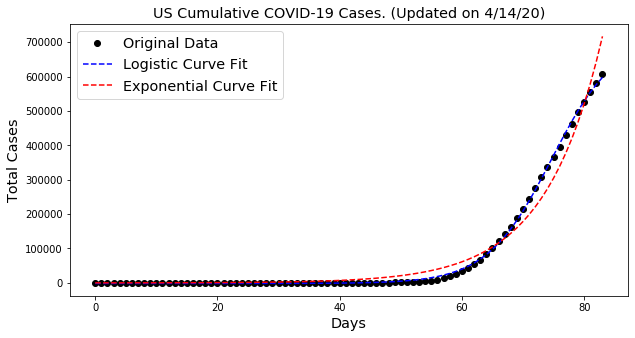



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 172541
	Confirmed cases on 4/7/20 	 141942
	Ratio: 1.22
	Weekly increase: 21.6 %
	Daily increase: 2.8 % per day
	Doubling Time (represents recent growth): 24.9 days

** Based on Logistic Fit**

	R^2: 0.9993975920445586
	Doubling Time (during middle of growth):  7.39 (± 0.2 ) days
	param:  [ 5.68287071e+04  1.87632321e-01 -6.88738420e+02  1.80343131e+05]

 exponential R^2  0.8810435472351248


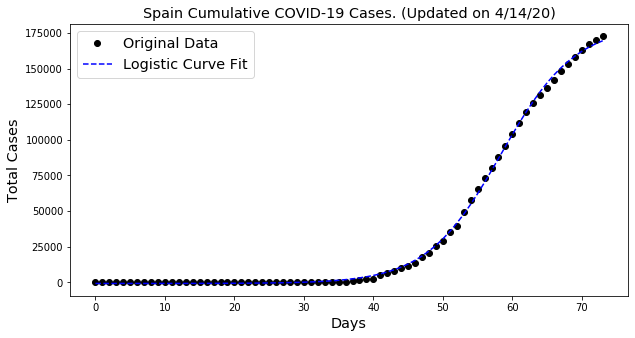



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 162488
	Confirmed cases on 4/7/20 	 135586
	Ratio: 1.2
	Weekly increase: 19.8 %
	Daily increase: 2.6 % per day
	Doubling Time (represents recent growth): 26.8 days

** Based on Logistic Fit**

	R^2: 0.9984974527743183
	Doubling Time (during middle of growth):  9.83 (± 0.42 ) days
	param:  [ 2.67049964e+03  1.41086052e-01 -1.44119290e+03  1.68855889e+05]

 exponential R^2  0.7790133114425586


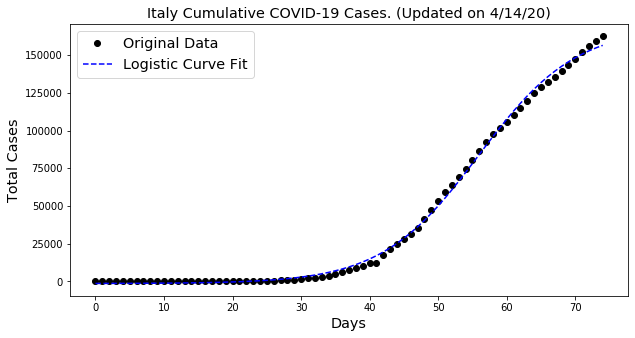



France

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 131361
	Confirmed cases on 4/7/20 	 110065
	Ratio: 1.19
	Weekly increase: 19.3 %
	Daily increase: 2.6 % per day
	Doubling Time (represents recent growth): 27.4 days

** Based on Logistic Fit**

	R^2: 0.9964262391507311
	Doubling Time (during middle of growth):  7.65 (± 0.5 ) days
	param:  [3.70334920e+05 1.81186233e-01 1.69884371e+02 1.62841006e+05]

** Based on Exponential Fit **

	R^2: 0.9658018362624489
	Doubling Time (represents overall growth):  7.55 (± 0.68 ) days
	param:  [ 1.00000000e+02  9.17948887e-02 -1.00000000e+02]


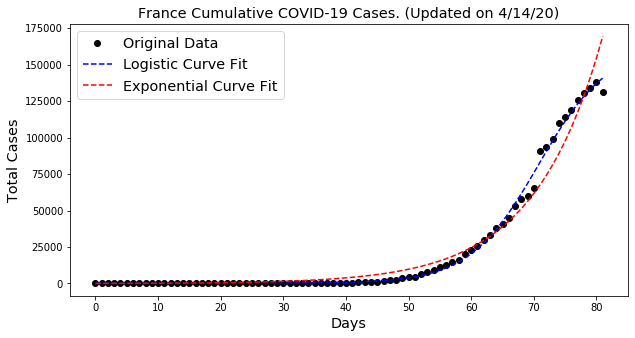



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 131359
	Confirmed cases on 4/7/20 	 107663
	Ratio: 1.22
	Weekly increase: 22.0 %
	Daily increase: 2.9 % per day
	Doubling Time (represents recent growth): 24.4 days

** Based on Logistic Fit**

	R^2: 0.9992866143023522
	Doubling Time (during middle of growth):  7.8 (± 0.22 ) days
	param:  [ 8.04940057e+04  1.77757274e-01 -5.32679424e+02  1.40318745e+05]

 exponential R^2  0.915706923826559


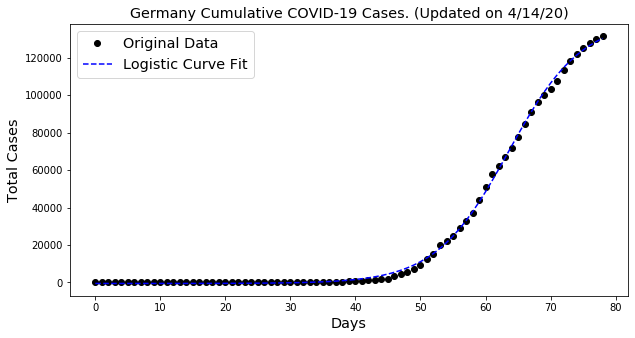



United Kingdom

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 94845
	Confirmed cases on 4/7/20 	 55949
	Ratio: 1.7
	Weekly increase: 69.5 %
	Daily increase: 7.8 % per day
	Doubling Time (represents recent growth): 9.2 days

** Based on Logistic Fit**

	R^2: 0.9993558656053138
	Doubling Time (during middle of growth):  8.22 (± 0.25 ) days
	param:  [ 1.01762213e+05  1.68619150e-01 -2.48200215e+02  1.30686783e+05]

** Based on Exponential Fit **

	R^2: 0.9867953295216777
	Doubling Time (represents overall growth):  6.83 (± 0.4 ) days
	param:  [  57.63027647    0.10145193 -100.        ]


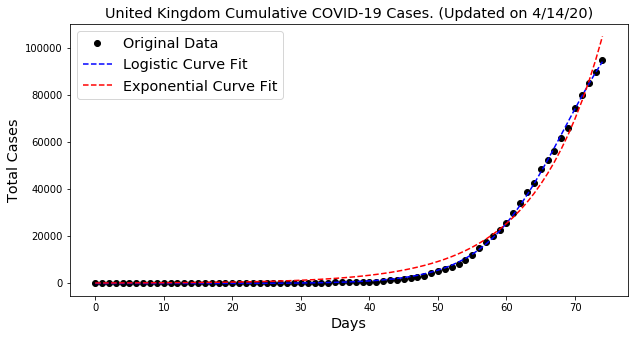



China

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 83306
	Confirmed cases on 4/7/20 	 82718
	Ratio: 1.01
	Weekly increase: 0.7 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 685.0 days

** Based on Logistic Fit**

	R^2: 0.9958084685709233
	Doubling Time (during middle of growth):  6.66 (± 0.45 ) days
	param:  [ 3.90261988e+01  2.08254764e-01 -1.79375690e+03  8.17467863e+04]

 exponential R^2  -2.78040912011052


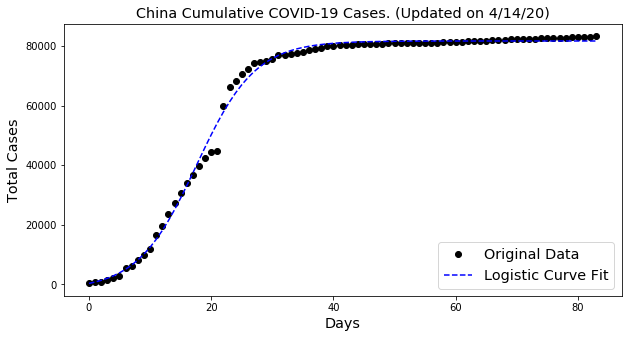



Iran

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 74877
	Confirmed cases on 4/7/20 	 62589
	Ratio: 1.2
	Weekly increase: 19.6 %
	Daily increase: 2.6 % per day
	Doubling Time (represents recent growth): 27.1 days

** Based on Logistic Fit**

	R^2: 0.9978919774953917
	Doubling Time (during middle of growth):  13.17 (± 1.0 ) days
	param:  [ 8.60819342e+01  1.05258801e-01 -1.44571456e+03  9.63790601e+04]

 exponential R^2  0.6391943708557196


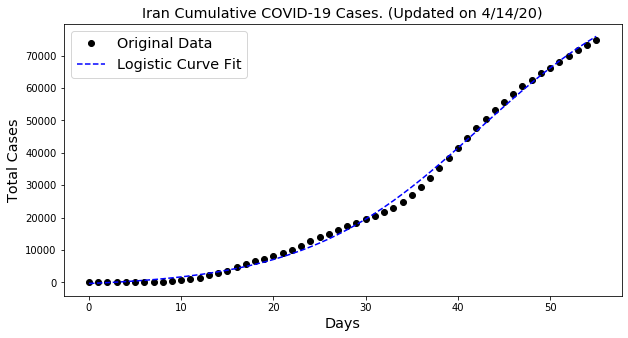



Turkey

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 65111
	Confirmed cases on 4/7/20 	 34109
	Ratio: 1.91
	Weekly increase: 90.9 %
	Daily increase: 9.7 % per day
	Doubling Time (represents recent growth): 7.5 days

** Based on Logistic Fit**

	R^2: 0.9989367497021392
	Doubling Time (during middle of growth):  7.82 (± 0.56 ) days
	param:  [ 2.17457998e+02  1.77331652e-01 -1.38109464e+03  9.96929390e+04]

 exponential R^2  0.8633607655931459


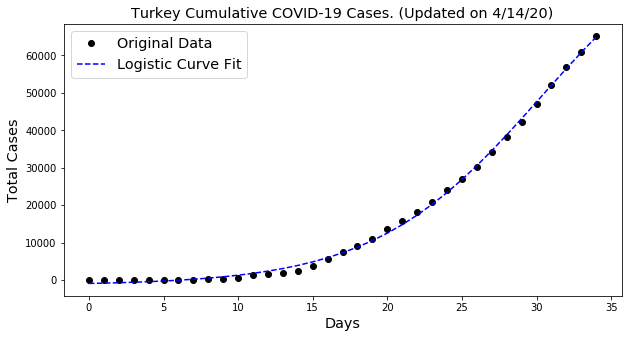



Belgium

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 31119
	Confirmed cases on 4/7/20 	 22194
	Ratio: 1.4
	Weekly increase: 40.2 %
	Daily increase: 4.9 % per day
	Doubling Time (represents recent growth): 14.4 days

** Based on Logistic Fit**

	R^2: 0.9987400404404009
	Doubling Time (during middle of growth):  8.14 (± 0.34 ) days
	param:  [ 2.71489608e+04  1.70374356e-01 -1.23579792e+02  3.64347197e+04]

** Based on Exponential Fit **

	R^2: 0.9737801115947182
	Doubling Time (represents overall growth):  8.24 (± 0.74 ) days
	param:  [ 9.99999995e+01  8.41374743e-02 -1.00000000e+02]


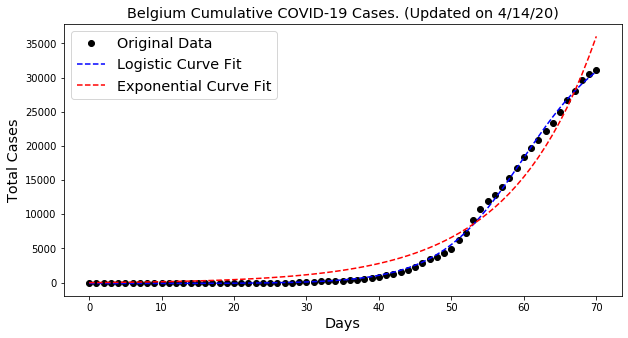



Netherlands

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 27580
	Confirmed cases on 4/7/20 	 19709
	Ratio: 1.4
	Weekly increase: 39.9 %
	Daily increase: 4.9 % per day
	Doubling Time (represents recent growth): 14.4 days

** Based on Logistic Fit**

	R^2: 0.9982588208971043
	Doubling Time (during middle of growth):  9.9 (± 0.69 ) days
	param:  [ 1.66812277e+02  1.40083546e-01 -5.75584075e+02  3.33227442e+04]

 exponential R^2  0.8408891932564737


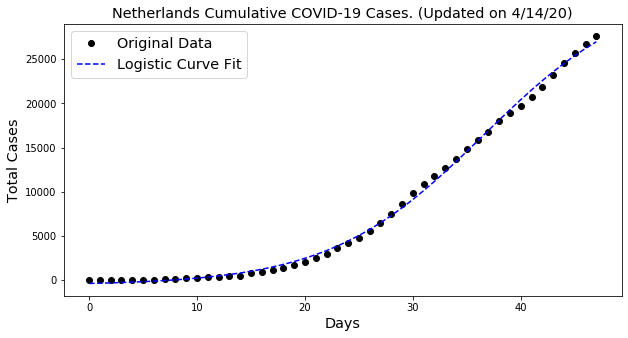



Canada

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 27034
	Confirmed cases on 4/7/20 	 17872
	Ratio: 1.51
	Weekly increase: 51.3 %
	Daily increase: 6.1 % per day
	Doubling Time (represents recent growth): 11.7 days

** Based on Logistic Fit**

	R^2: 0.9992641887238227
	Doubling Time (during middle of growth):  7.41 (± 0.23 ) days
	param:  [ 5.34284123e+05  1.86977867e-01 -6.03227652e+01  3.18941789e+04]

** Based on Exponential Fit **

	R^2: 0.9785903975233411
	Doubling Time (represents overall growth):  7.31 (± 0.53 ) days
	param:  [ 1.70918925e+01  9.48171367e-02 -1.00000000e+02]


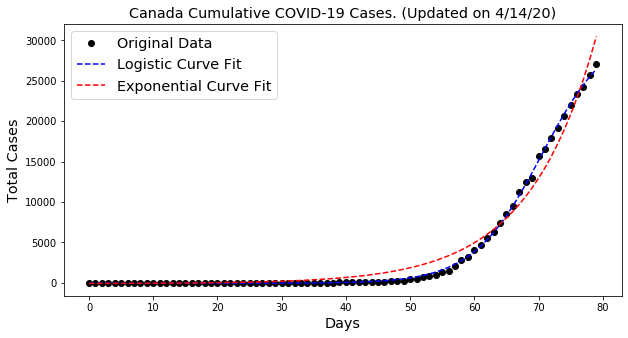



Switzerland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 25936
	Confirmed cases on 4/7/20 	 22253
	Ratio: 1.17
	Weekly increase: 16.6 %
	Daily increase: 2.2 % per day
	Doubling Time (represents recent growth): 31.7 days

** Based on Logistic Fit**

	R^2: 0.9980462923106892
	Doubling Time (during middle of growth):  8.12 (± 0.5 ) days
	param:  [ 2.19282285e+02  1.70647954e-01 -5.29552138e+02  2.68625404e+04]

 exponential R^2  0.6701268345968971


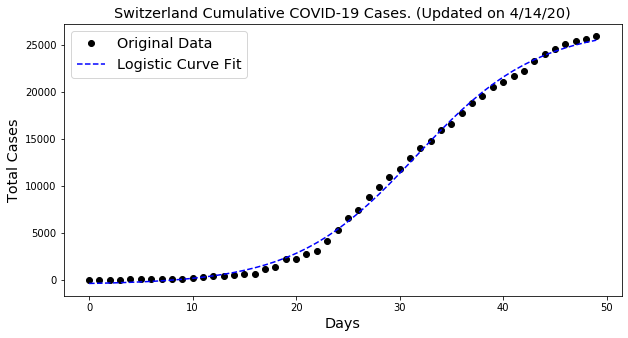



Brazil

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 25262
	Confirmed cases on 4/7/20 	 14034
	Ratio: 1.8
	Weekly increase: 80.0 %
	Daily increase: 8.8 % per day
	Doubling Time (represents recent growth): 8.3 days

** Based on Logistic Fit**

	R^2: 0.998946105981656
	Doubling Time (during middle of growth):  8.09 (± 0.42 ) days
	param:  [ 1.77383278e+03  1.71369212e-01 -1.12442734e+02  3.72506766e+04]

** Based on Exponential Fit **

	R^2: 0.9833371633975628
	Doubling Time (represents overall growth):  5.88 (± 0.51 ) days
	param:  [100.           0.11793555 -67.14454653]


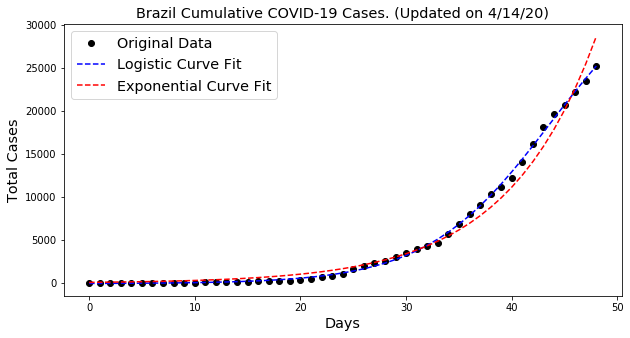



Russia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 21102
	Confirmed cases on 4/7/20 	 7497
	Ratio: 2.81
	Weekly increase: 181.5 %
	Daily increase: 15.9 % per day
	Doubling Time (represents recent growth): 4.7 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.999081673742386
	Doubling Time (represents overall growth):  4.54 (± 0.07 ) days
	param:  [  0.26692439   0.15265516 -74.96545156]


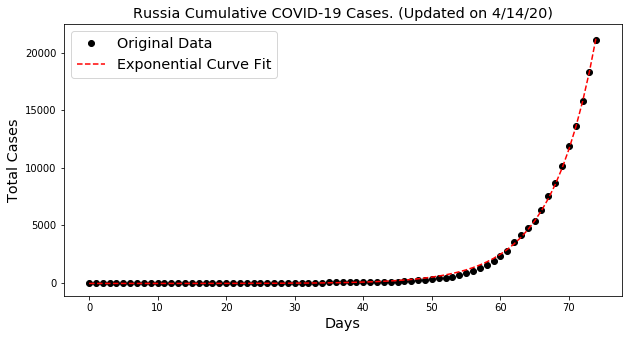



Portugal

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 17448
	Confirmed cases on 4/7/20 	 12442
	Ratio: 1.4
	Weekly increase: 40.2 %
	Daily increase: 4.9 % per day
	Doubling Time (represents recent growth): 14.3 days

** Based on Logistic Fit**

	R^2: 0.9978653759249282
	Doubling Time (during middle of growth):  7.99 (± 0.59 ) days
	param:  [ 2.67449440e+02  1.73553119e-01 -3.17623371e+02  1.99195625e+04]

 exponential R^2  0.8737646131549887


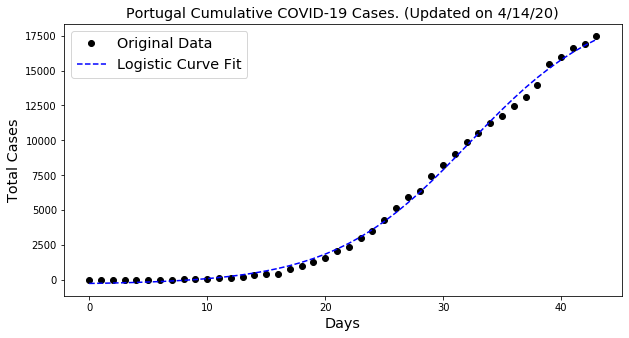



Austria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 14226
	Confirmed cases on 4/7/20 	 12639
	Ratio: 1.13
	Weekly increase: 12.6 %
	Daily increase: 1.7 % per day
	Doubling Time (represents recent growth): 41.0 days

** Based on Logistic Fit**

	R^2: 0.9987232628042617
	Doubling Time (during middle of growth):  6.35 (± 0.3 ) days
	param:  [ 7.88683303e+02  2.18148606e-01 -1.28307159e+02  1.40431649e+04]

 exponential R^2  0.7193256482077635


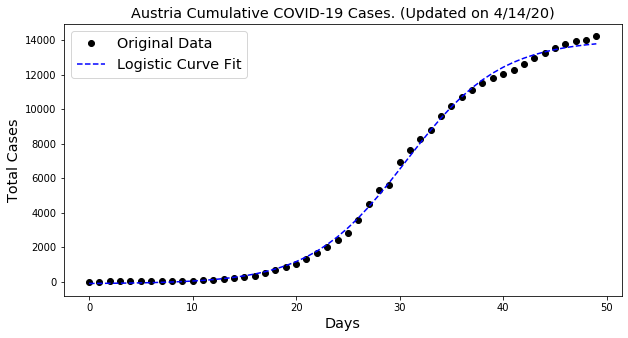



Israel

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 12046
	Confirmed cases on 4/7/20 	 9248
	Ratio: 1.3
	Weekly increase: 30.3 %
	Daily increase: 3.8 % per day
	Doubling Time (represents recent growth): 18.4 days

** Based on Logistic Fit**

	R^2: 0.9978267045946374
	Doubling Time (during middle of growth):  6.37 (± 0.39 ) days
	param:  [ 6.20747786e+03  2.17538048e-01 -6.13850800e+01  1.21554053e+04]

 exponential R^2  0.9364966600114487


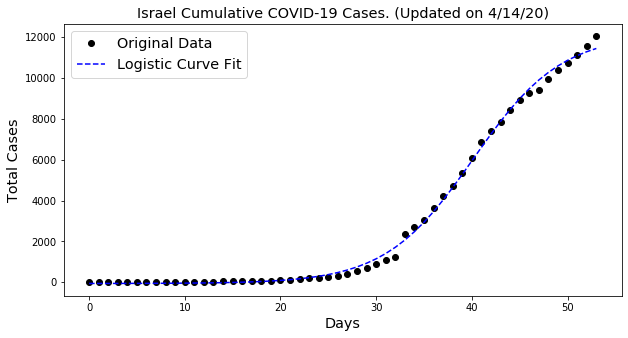



India

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 11487
	Confirmed cases on 4/7/20 	 5311
	Ratio: 2.16
	Weekly increase: 116.3 %
	Daily increase: 11.7 % per day
	Doubling Time (represents recent growth): 6.3 days

** Based on Logistic Fit**

	R^2: 0.9989334615405574
	Doubling Time (during middle of growth):  7.24 (± 0.3 ) days
	param:  [1.33534693e+06 1.91538490e-01 1.12789445e+01 2.01365494e+04]

** Based on Exponential Fit **

	R^2: 0.9944980146383426
	Doubling Time (represents overall growth):  5.3 (± 0.19 ) days
	param:  [  0.66754862   0.13082504 -69.77239254]


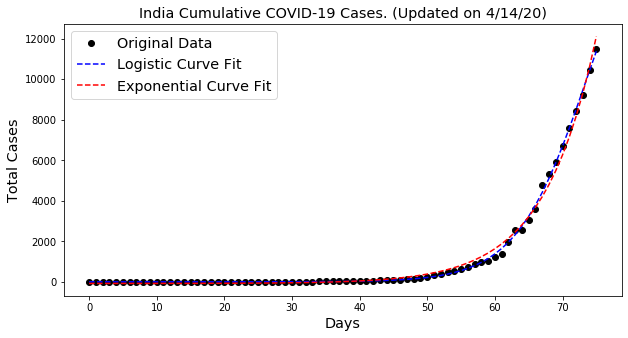



Ireland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 11479
	Confirmed cases on 4/7/20 	 5709
	Ratio: 2.01
	Weekly increase: 101.1 %
	Daily increase: 10.5 % per day
	Doubling Time (represents recent growth): 6.9 days

** Based on Logistic Fit**

	R^2: 0.9957907612229293
	Doubling Time (during middle of growth):  14.87 (± 2.79 ) days
	param:  [ 1.00122857e+03  9.32304943e-02 -4.09987957e+02  1.90973965e+05]

** Based on Exponential Fit **

	R^2: 0.9907891732453094
	Doubling Time (represents overall growth):  6.5 (± 0.45 ) days
	param:  [100.           0.10656983 -39.04402493]


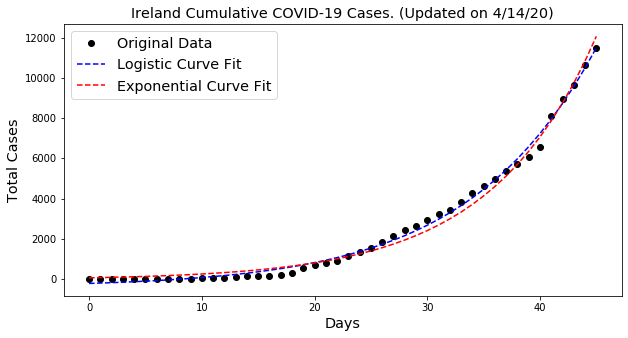



Sweden

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 11445
	Confirmed cases on 4/7/20 	 7693
	Ratio: 1.49
	Weekly increase: 48.8 %
	Daily increase: 5.8 % per day
	Doubling Time (represents recent growth): 12.2 days

** Based on Logistic Fit**

	R^2: 0.9990083176807659
	Doubling Time (during middle of growth):  11.74 (± 0.48 ) days
	param:  [ 3.41996724e+03  1.18076111e-01 -5.97570538e+01  1.78853362e+04]

** Based on Exponential Fit **

	R^2: 0.9902969937141611
	Doubling Time (represents overall growth):  9.1 (± 0.48 ) days
	param:  [ 4.52098862e+01  7.62045793e-02 -1.00000000e+02]


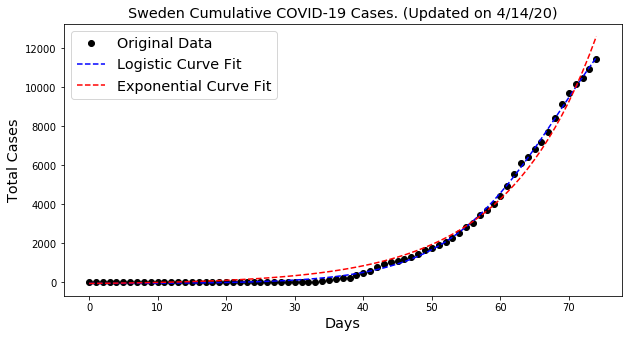



Korea, South

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 10564
	Confirmed cases on 4/7/20 	 10331
	Ratio: 1.02
	Weekly increase: 2.3 %
	Daily increase: 0.3 % per day
	Doubling Time (represents recent growth): 217.6 days

** Based on Logistic Fit**

	R^2: 0.9895438410929395
	Doubling Time (during middle of growth):  6.94 (± 0.75 ) days
	param:  [ 4.15372822e+03  1.99871709e-01 -1.73193257e+02  9.77342504e+03]

 exponential R^2  0.4951866018827946


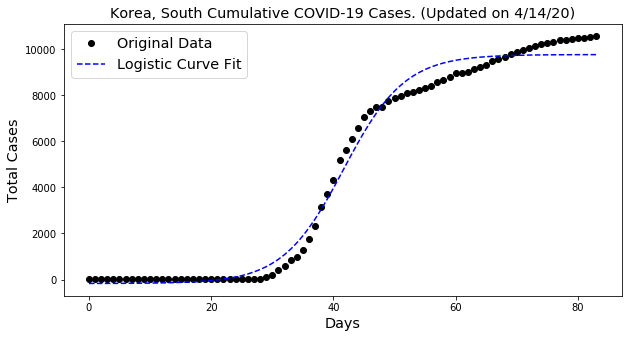



Peru

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 10303
	Confirmed cases on 4/7/20 	 2954
	Ratio: 3.49
	Weekly increase: 248.8 %
	Daily increase: 19.5 % per day
	Doubling Time (represents recent growth): 3.9 days

** Based on Logistic Fit**

	R^2: 0.9947210804775422
	Doubling Time (during middle of growth):  6.85 (± 1.02 ) days
	param:  [5.71932955e+03 2.02412504e-01 9.18207141e+01 3.29995441e+04]

** Based on Exponential Fit **

	R^2: 0.9938312782800768
	Doubling Time (represents overall growth):  4.22 (± 0.24 ) days
	param:  [17.88348325  0.16426827  2.85787854]


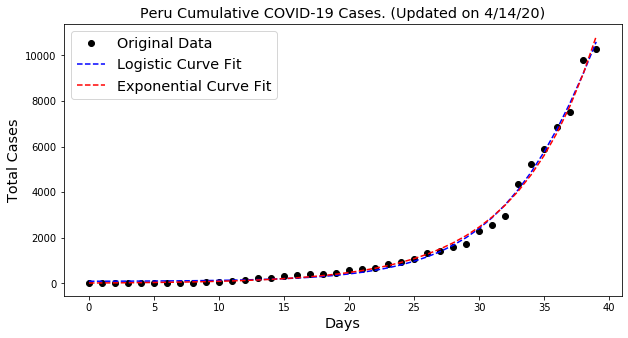



Chile

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 7917
	Confirmed cases on 4/7/20 	 5116
	Ratio: 1.55
	Weekly increase: 54.7 %
	Daily increase: 6.4 % per day
	Doubling Time (represents recent growth): 11.1 days

** Based on Logistic Fit**

	R^2: 0.9990000615495639
	Doubling Time (during middle of growth):  8.86 (± 0.5 ) days
	param:  [ 2.18513209e+02  1.56492784e-01 -1.48037188e+02  1.02637853e+04]

** Based on Exponential Fit **

	R^2: 0.9601191393094984
	Doubling Time (represents overall growth):  6.43 (± 1.01 ) days
	param:  [100.           0.10778836  99.99999958]


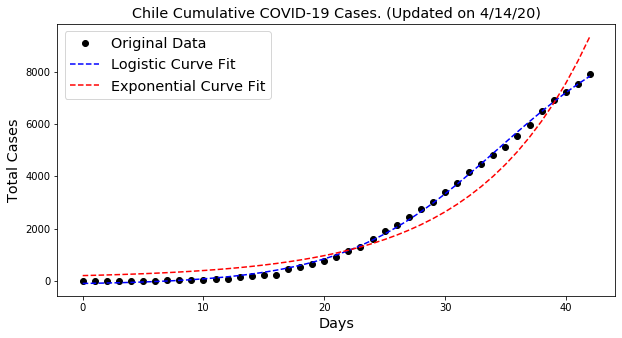



Japan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 7645
	Confirmed cases on 4/7/20 	 3906
	Ratio: 1.96
	Weekly increase: 95.7 %
	Daily increase: 10.1 % per day
	Doubling Time (represents recent growth): 7.2 days

** Based on Logistic Fit**

	R^2: 0.99445504220443
	Doubling Time (during middle of growth):  14.96 (± 1.17 ) days
	param:  [1.18635523e+11 9.26967862e-02 8.64396417e+01 4.14208499e+11]

** Based on Exponential Fit **

	R^2: 0.9944550423471228
	Doubling Time (represents overall growth):  7.48 (± 0.26 ) days
	param:  [ 3.49145835  0.09269671 86.43908514]


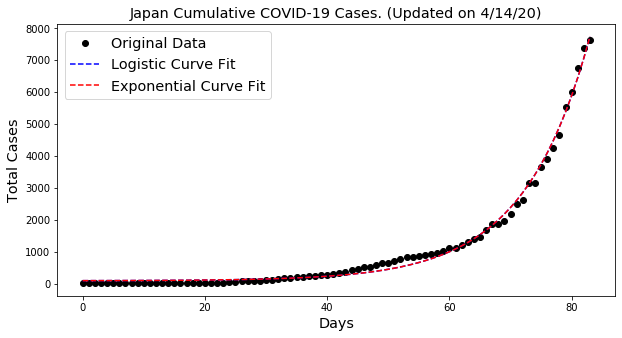



Ecuador

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 7603
	Confirmed cases on 4/7/20 	 3747
	Ratio: 2.03
	Weekly increase: 102.9 %
	Daily increase: 10.6 % per day
	Doubling Time (represents recent growth): 6.9 days

** Based on Logistic Fit**

	R^2: 0.9810404670475635
	Doubling Time (during middle of growth):  11.66 (± 3.62 ) days
	param:  [ 2.37680845e+02  1.18942424e-01 -2.07663150e+02  1.87222728e+04]

** Based on Exponential Fit **

	R^2: 0.9729508176785124
	Doubling Time (represents overall growth):  6.79 (± 0.85 ) days
	param:  [100.           0.10210851 -96.75273025]


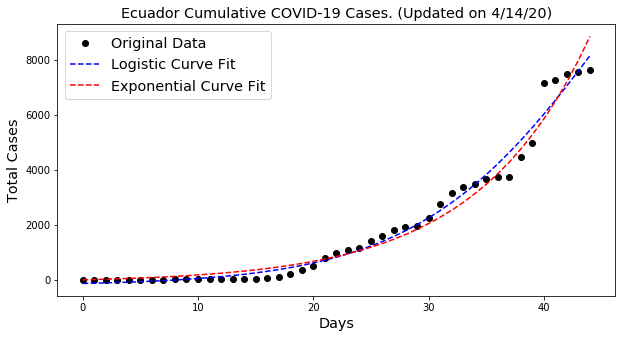



Poland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 7202
	Confirmed cases on 4/7/20 	 4848
	Ratio: 1.49
	Weekly increase: 48.6 %
	Daily increase: 5.8 % per day
	Doubling Time (represents recent growth): 12.3 days

** Based on Logistic Fit**

	R^2: 0.9997770376467977
	Doubling Time (during middle of growth):  8.6 (± 0.23 ) days
	param:  [ 2.27844286e+02  1.61139794e-01 -8.07053900e+01  9.49363660e+03]

** Based on Exponential Fit **

	R^2: 0.9634587922475284
	Doubling Time (represents overall growth):  6.4 (± 0.98 ) days
	param:  [100.           0.10828819 100.        ]


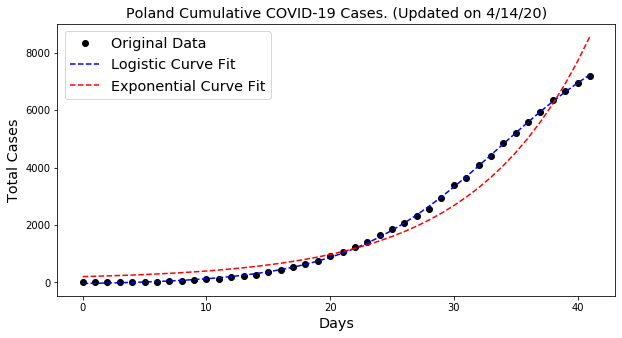



Romania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 6879
	Confirmed cases on 4/7/20 	 4417
	Ratio: 1.56
	Weekly increase: 55.7 %
	Daily increase: 6.5 % per day
	Doubling Time (represents recent growth): 11.0 days

** Based on Logistic Fit**

	R^2: 0.9988174850954614
	Doubling Time (during middle of growth):  8.44 (± 0.46 ) days
	param:  [ 7.97624427e+02  1.64168884e-01 -6.01842873e+01  8.90580755e+03]

** Based on Exponential Fit **

	R^2: 0.9815603866837355
	Doubling Time (represents overall growth):  7.64 (± 0.78 ) days
	param:  [ 1.00000000e+02  9.07706678e-02 -1.00000000e+02]


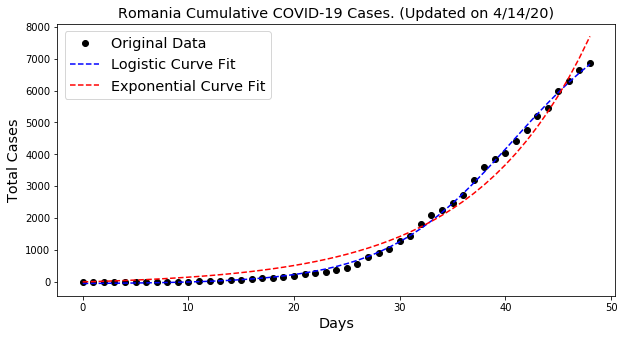



Denmark

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 6706
	Confirmed cases on 4/7/20 	 5266
	Ratio: 1.27
	Weekly increase: 27.3 %
	Daily increase: 3.5 % per day
	Doubling Time (represents recent growth): 20.1 days

** Based on Logistic Fit**

	R^2: 0.9955491617959351
	Doubling Time (during middle of growth):  13.58 (± 1.97 ) days
	param:  [ 6.36363516e+01  1.02082054e-01 -2.11757985e+02  1.06877328e+04]

 exponential R^2  0.9299954284857915


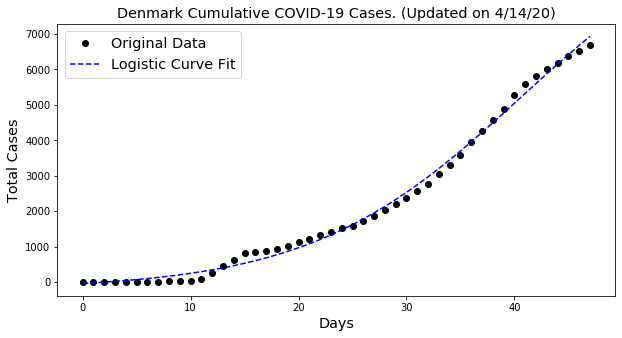



Norway

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 6623
	Confirmed cases on 4/7/20 	 6086
	Ratio: 1.09
	Weekly increase: 8.8 %
	Daily increase: 1.2 % per day
	Doubling Time (represents recent growth): 57.4 days

** Based on Logistic Fit**

	R^2: 0.9989463665603164
	Doubling Time (during middle of growth):  9.8 (± 0.48 ) days
	param:  [ 6.13354867e+01  1.41413134e-01 -2.04121101e+02  7.13707445e+03]

 exponential R^2  0.7400817096931618


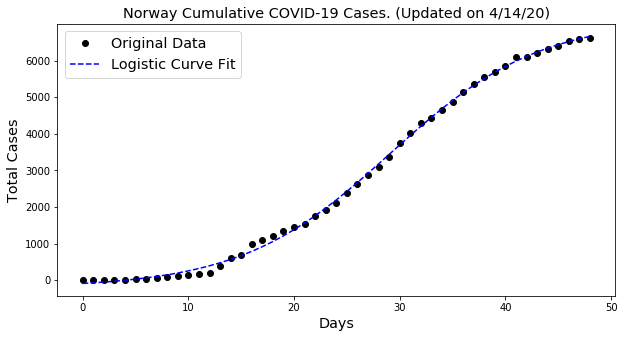



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 6415
	Confirmed cases on 4/7/20 	 5895
	Ratio: 1.09
	Weekly increase: 8.8 %
	Daily increase: 1.2 % per day
	Doubling Time (represents recent growth): 57.4 days

** Based on Logistic Fit**

	R^2: 0.9996418565579829
	Doubling Time (during middle of growth):  5.62 (± 0.11 ) days
	param:  [3.57607767e+06 2.46777847e-01 9.50943526e+00 6.38807809e+03]

 exponential R^2  0.9227325907627933


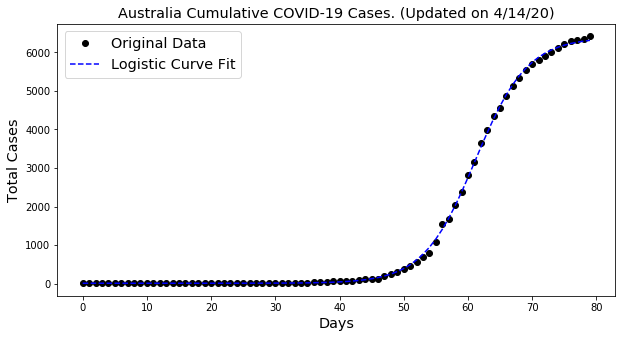



Czechia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 6111
	Confirmed cases on 4/7/20 	 5017
	Ratio: 1.22
	Weekly increase: 21.8 %
	Daily increase: 2.9 % per day
	Doubling Time (represents recent growth): 24.6 days

** Based on Logistic Fit**

	R^2: 0.9991831716019743
	Doubling Time (during middle of growth):  8.11 (± 0.36 ) days
	param:  [ 1.69037232e+02  1.70872793e-01 -1.07087645e+02  6.71426487e+03]

 exponential R^2  0.8812275809994045


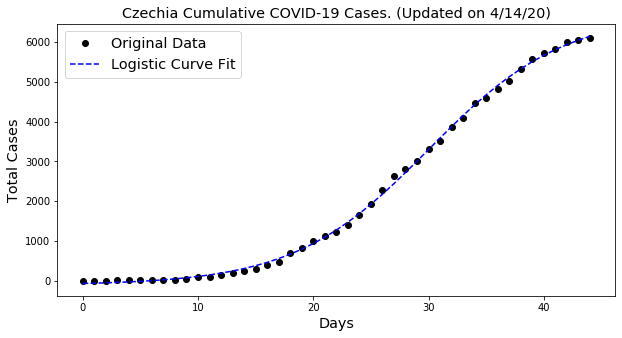



Pakistan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 5837
	Confirmed cases on 4/7/20 	 4035
	Ratio: 1.45
	Weekly increase: 44.7 %
	Daily increase: 5.4 % per day
	Doubling Time (represents recent growth): 13.1 days

** Based on Logistic Fit**

	R^2: 0.9974500665055952
	Doubling Time (during middle of growth):  10.05 (± 0.87 ) days
	param:  [ 3.28499580e+02  1.37974366e-01 -8.78086783e+01  8.38494668e+03]

** Based on Exponential Fit **

	R^2: 0.9830466203897352
	Doubling Time (represents overall growth):  7.94 (± 0.78 ) days
	param:  [ 1.00000000e+02  8.73371638e-02 -1.00000000e+02]


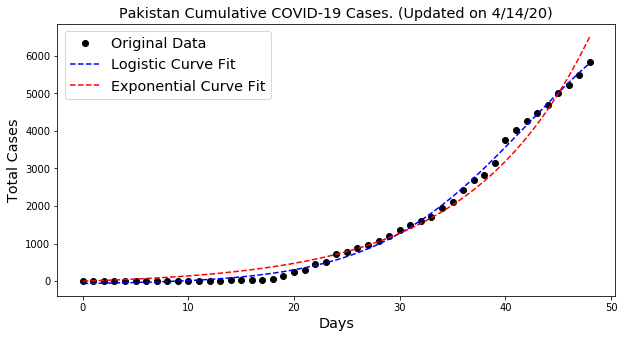



Saudi Arabia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 5369
	Confirmed cases on 4/7/20 	 2795
	Ratio: 1.92
	Weekly increase: 92.1 %
	Daily increase: 9.8 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.9967123292893206
	Doubling Time (during middle of growth):  16.86 (± 2.54 ) days
	param:  [ 1.14340355e+08  8.22469989e-02 -2.74260438e+02  1.85328701e+10]

** Based on Exponential Fit **

	R^2: 0.9943865578020915
	Doubling Time (represents overall growth):  7.42 (± 0.45 ) days
	param:  [ 1.00000000e+02  9.34006941e-02 -1.00000000e+02]


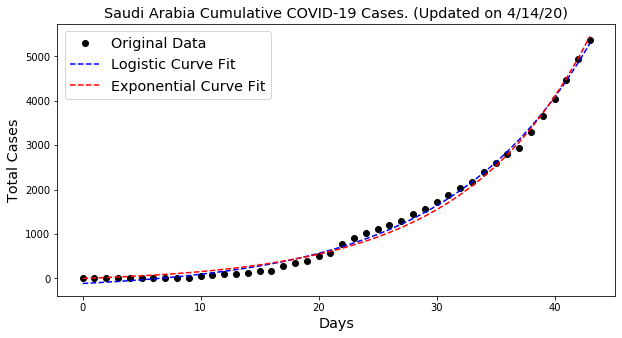



Philippines

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 5223
	Confirmed cases on 4/7/20 	 3764
	Ratio: 1.39
	Weekly increase: 38.8 %
	Daily increase: 4.8 % per day
	Doubling Time (represents recent growth): 14.8 days

** Based on Logistic Fit**

	R^2: 0.9969213125643048
	Doubling Time (during middle of growth):  6.3 (± 0.39 ) days
	param:  [1.19609624e+06 2.20087727e-01 6.44044825e-01 5.28067972e+03]

** Based on Exponential Fit **

	R^2: 0.9658457155666103
	Doubling Time (represents overall growth):  8.25 (± 0.8 ) days
	param:  [ 1.09761669e+01  8.40124904e-02 -1.00000000e+02]


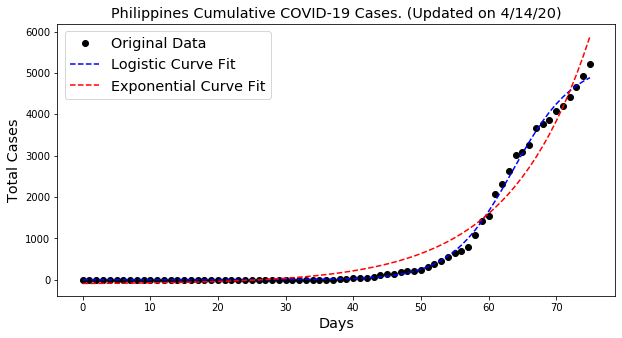



Mexico

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 5014
	Confirmed cases on 4/7/20 	 2439
	Ratio: 2.06
	Weekly increase: 105.6 %
	Daily increase: 10.8 % per day
	Doubling Time (represents recent growth): 6.7 days

** Based on Logistic Fit**

	R^2: 0.9992607153209329
	Doubling Time (during middle of growth):  9.7 (± 0.51 ) days
	param:  [ 1.02105089e+03  1.42924815e-01 -4.42192898e+01  1.22966212e+04]

** Based on Exponential Fit **

	R^2: 0.9973440491117118
	Doubling Time (represents overall growth):  6.35 (± 0.23 ) days
	param:  [  35.22830179    0.10919016 -100.        ]


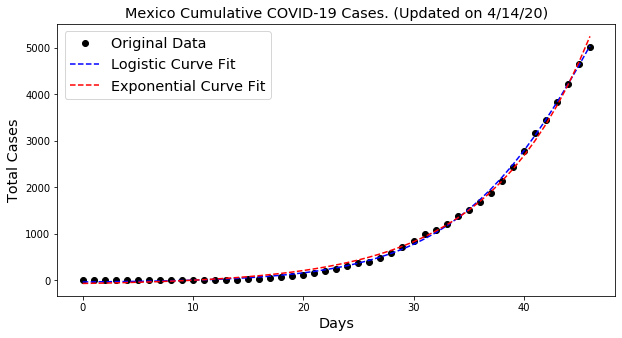



Malaysia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 4987
	Confirmed cases on 4/7/20 	 3963
	Ratio: 1.26
	Weekly increase: 25.8 %
	Daily increase: 3.3 % per day
	Doubling Time (represents recent growth): 21.1 days

** Based on Logistic Fit**

	R^2: 0.9976991321805778
	Doubling Time (during middle of growth):  9.6 (± 0.5 ) days
	param:  [ 1.23569848e+04  1.44440433e-01 -2.31016364e+01  5.35729322e+03]

** Based on Exponential Fit **

	R^2: 0.968037233678175
	Doubling Time (represents overall growth):  11.18 (± 1.1 ) days
	param:  [ 4.08861653e+01  6.19763355e-02 -1.00000000e+02]


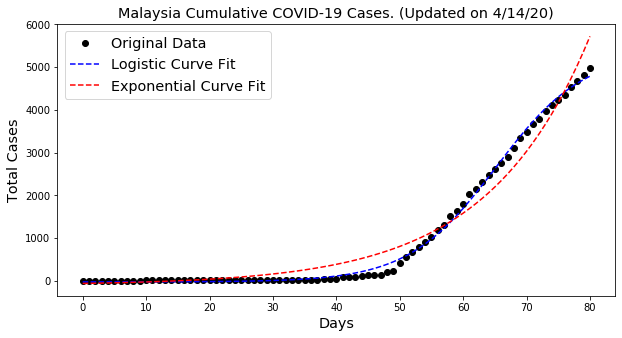



United Arab Emirates

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 4933
	Confirmed cases on 4/7/20 	 2359
	Ratio: 2.09
	Weekly increase: 109.1 %
	Daily increase: 11.1 % per day
	Doubling Time (represents recent growth): 6.6 days

** Based on Logistic Fit**

	R^2: 0.9993690214888973
	Doubling Time (during middle of growth):  7.15 (± 0.22 ) days
	param:  [1.61876309e+06 1.93978456e-01 2.09413144e+01 8.03967979e+03]

** Based on Exponential Fit **

	R^2: 0.9938870364849539
	Doubling Time (represents overall growth):  5.48 (± 0.2 ) days
	param:  [  0.35461213   0.12642945 -19.57754497]


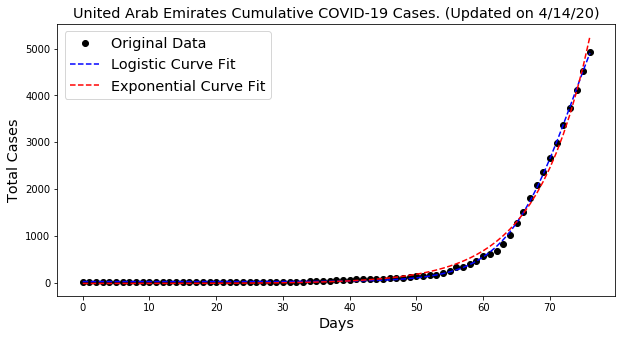



Indonesia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 4839
	Confirmed cases on 4/7/20 	 2738
	Ratio: 1.77
	Weekly increase: 76.7 %
	Daily increase: 8.5 % per day
	Doubling Time (represents recent growth): 8.5 days

** Based on Logistic Fit**

	R^2: 0.9983828438649925
	Doubling Time (during middle of growth):  14.45 (± 1.67 ) days
	param:  [ 1.59820975e+02  9.59425209e-02 -2.00544027e+02  1.78674175e+04]

** Based on Exponential Fit **

	R^2: 0.9937549325548994
	Doubling Time (represents overall growth):  7.53 (± 0.48 ) days
	param:  [ 1.0000000e+02  9.2016786e-02 -9.5015821e+01]


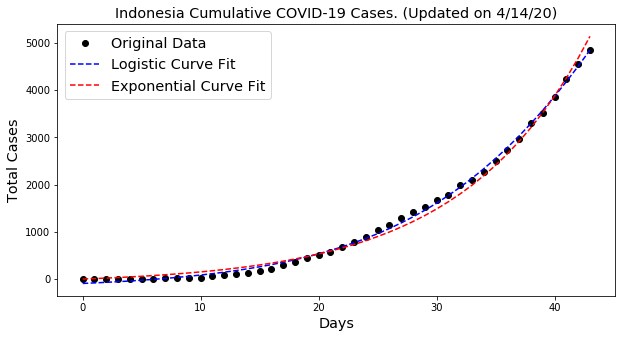



Serbia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 4465
	Confirmed cases on 4/7/20 	 2447
	Ratio: 1.82
	Weekly increase: 82.5 %
	Daily increase: 9.0 % per day
	Doubling Time (represents recent growth): 8.1 days

** Based on Logistic Fit**

	R^2: 0.9984948887120622
	Doubling Time (during middle of growth):  8.48 (± 0.66 ) days
	param:  [ 3.75730745e+02  1.63524337e-01 -3.64484706e+01  7.12559639e+03]

** Based on Exponential Fit **

	R^2: 0.9922615169721873
	Doubling Time (represents overall growth):  6.57 (± 0.49 ) days
	param:  [  77.57875902    0.10557525 -100.        ]


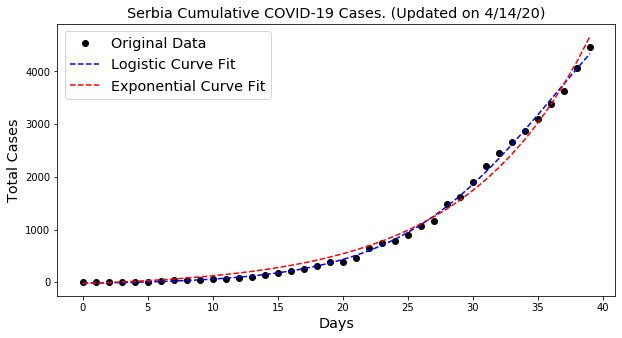



Panama

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 3472
	Confirmed cases on 4/7/20 	 2100
	Ratio: 1.65
	Weekly increase: 65.3 %
	Daily increase: 7.4 % per day
	Doubling Time (represents recent growth): 9.7 days

** Based on Logistic Fit**

	R^2: 0.9981345402338296
	Doubling Time (during middle of growth):  10.96 (± 1.32 ) days
	param:  [ 5.97775013e+01  1.26517144e-01 -1.51645885e+02  6.17903435e+03]

** Based on Exponential Fit **

	R^2: 0.9750915432764818
	Doubling Time (represents overall growth):  6.59 (± 0.99 ) days
	param:  [100.           0.10523952  14.94359111]


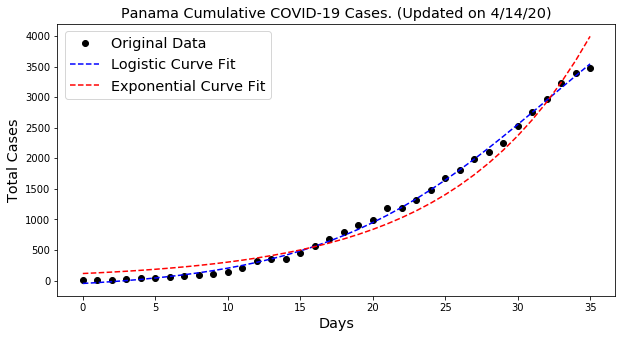



Qatar

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 3428
	Confirmed cases on 4/7/20 	 2057
	Ratio: 1.67
	Weekly increase: 66.7 %
	Daily increase: 7.6 % per day
	Doubling Time (represents recent growth): 9.5 days

** Based on Logistic Fit**

	R^2: 0.9826084493784475
	Doubling Time (during middle of growth):  12.15 (± 3.79 ) days
	param:  [5.13994243e+02 1.14110706e-01 6.39296254e+01 1.40345175e+04]

** Based on Exponential Fit **

	R^2: 0.9823197475900323
	Doubling Time (represents overall growth):  7.29 (± 0.74 ) days
	param:  [49.53609358  0.09506189 12.09639636]


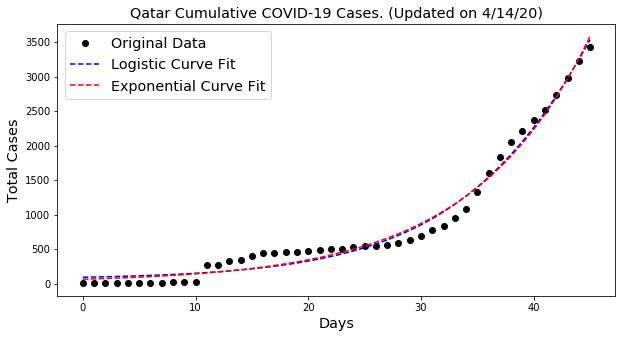



Ukraine

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 3372
	Confirmed cases on 4/7/20 	 1462
	Ratio: 2.31
	Weekly increase: 130.6 %
	Daily increase: 12.7 % per day
	Doubling Time (represents recent growth): 5.8 days

** Based on Logistic Fit**

	R^2: 0.9954575061444633
	Doubling Time (during middle of growth):  9.54 (± 1.37 ) days
	param:  [ 7.38712771e+02  1.45304404e-01 -5.88517461e+01  9.01033992e+03]

** Based on Exponential Fit **

	R^2: 0.9939704202961376
	Doubling Time (represents overall growth):  6.1 (± 0.36 ) days
	param:  [  30.30994663    0.11361626 -100.        ]


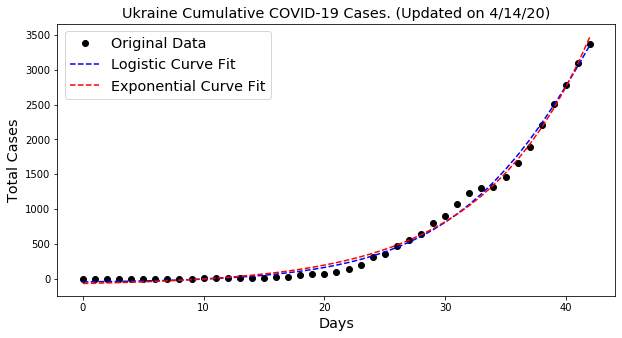



Luxembourg

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 3307
	Confirmed cases on 4/7/20 	 2970
	Ratio: 1.11
	Weekly increase: 11.3 %
	Daily increase: 1.5 % per day
	Doubling Time (represents recent growth): 45.1 days

** Based on Logistic Fit**

	R^2: 0.997296850119832
	Doubling Time (during middle of growth):  6.61 (± 0.48 ) days
	param:  [ 3.20583711e+02  2.09615176e-01 -7.52529508e+01  3.35385622e+03]

 exponential R^2  0.8620977331213747


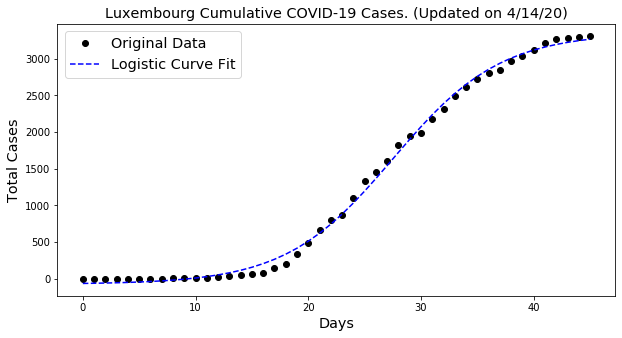



Dominican Republic

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 3286
	Confirmed cases on 4/7/20 	 1956
	Ratio: 1.68
	Weekly increase: 68.0 %
	Daily increase: 7.7 % per day
	Doubling Time (represents recent growth): 9.4 days

** Based on Logistic Fit**

	R^2: 0.9954448151653851
	Doubling Time (during middle of growth):  9.18 (± 1.11 ) days
	param:  [ 3.16015294e+02  1.50943469e-01 -7.28566021e+01  4.61897971e+03]

** Based on Exponential Fit **

	R^2: 0.9828461731361188
	Doubling Time (represents overall growth):  7.71 (± 0.83 ) days
	param:  [ 7.08918667e+01  8.99315035e-02 -1.00000000e+02]


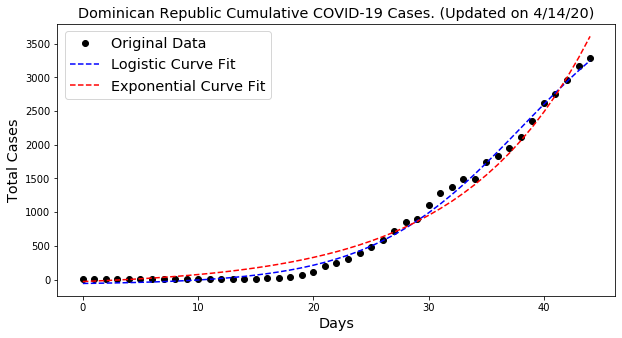



Belarus

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 3281
	Confirmed cases on 4/7/20 	 861
	Ratio: 3.81
	Weekly increase: 281.1 %
	Daily increase: 21.1 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Logistic Fit**

	R^2: 0.9977053661228457
	Doubling Time (during middle of growth):  4.26 (± 0.32 ) days
	param:  [1.35102830e+06 3.25386632e-01 3.25105969e+01 4.67127071e+03]

** Based on Exponential Fit **

	R^2: 0.9889980547763382
	Doubling Time (represents overall growth):  3.72 (± 0.24 ) days
	param:  [ 0.6656878   0.18650865 -9.13173851]


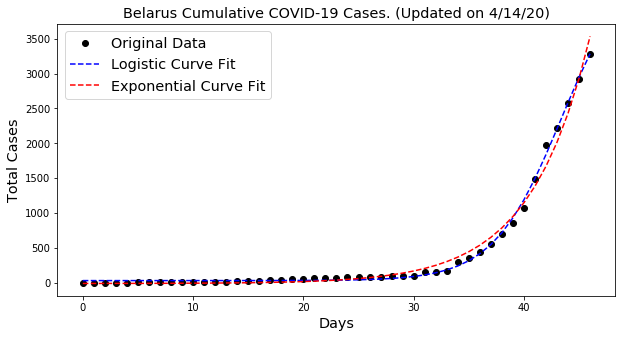



Singapore

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 3252
	Confirmed cases on 4/7/20 	 1481
	Ratio: 2.2
	Weekly increase: 119.6 %
	Daily increase: 11.9 % per day
	Doubling Time (represents recent growth): 6.2 days

** Based on Logistic Fit**

	R^2: 0.9942602814423104
	Doubling Time (during middle of growth):  15.33 (± 0.49 ) days
	param:  [5.35575472e+10 9.04116466e-02 4.01871703e+01 9.76028228e+10]

** Based on Exponential Fit **

	R^2: 0.994260281722922
	Doubling Time (represents overall growth):  7.67 (± 0.27 ) days
	param:  [ 1.82240589  0.09041155 40.18685452]


/home/ma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning:

invalid value encountered in sqrt



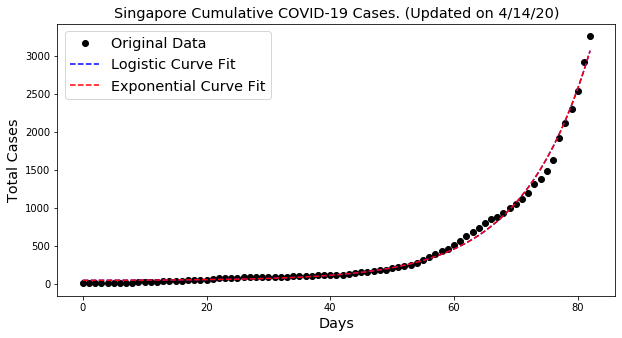



Finland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 3161
	Confirmed cases on 4/7/20 	 2308
	Ratio: 1.37
	Weekly increase: 37.0 %
	Daily increase: 4.6 % per day
	Doubling Time (represents recent growth): 15.4 days

** Based on Logistic Fit**

	R^2: 0.997122513082507
	Doubling Time (during middle of growth):  11.26 (± 0.74 ) days
	param:  [ 4.31224612e+03  1.23076245e-01 -2.63842218e+01  4.38618979e+03]

** Based on Exponential Fit **

	R^2: 0.9860018728903429
	Doubling Time (represents overall growth):  10.08 (± 0.64 ) days
	param:  [ 1.95264392e+01  6.87706761e-02 -1.00000000e+02]


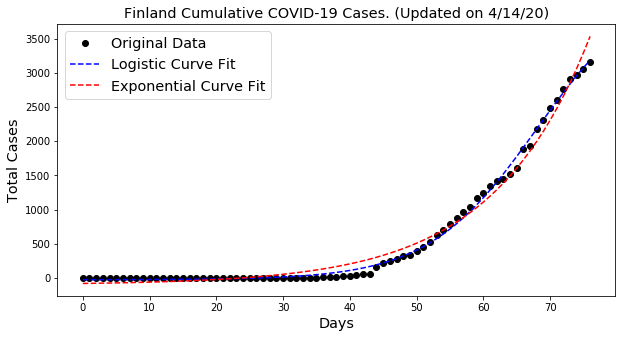



Colombia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 2979
	Confirmed cases on 4/7/20 	 1780
	Ratio: 1.67
	Weekly increase: 67.4 %
	Daily increase: 7.6 % per day
	Doubling Time (represents recent growth): 9.4 days

** Based on Logistic Fit**

	R^2: 0.9973769583790443
	Doubling Time (during middle of growth):  9.71 (± 1.07 ) days
	param:  [ 1.43688739e+02  1.42727092e-01 -6.34606426e+01  4.77249752e+03]

** Based on Exponential Fit **

	R^2: 0.9872841442172273
	Doubling Time (represents overall growth):  7.64 (± 0.79 ) days
	param:  [ 1.00000000e+02  9.07169088e-02 -1.00000000e+02]


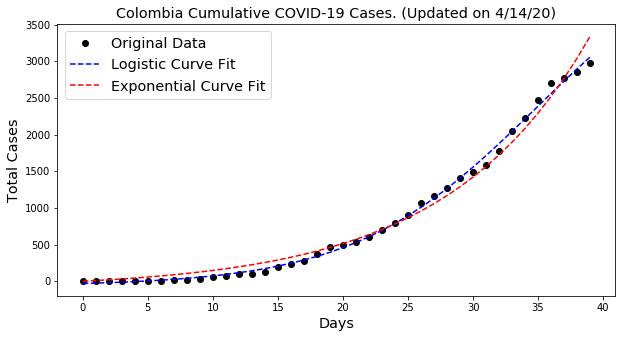



Thailand

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 2613
	Confirmed cases on 4/7/20 	 2258
	Ratio: 1.16
	Weekly increase: 15.7 %
	Daily increase: 2.1 % per day
	Doubling Time (represents recent growth): 33.2 days

** Based on Logistic Fit**

	R^2: 0.9987751019591419
	Doubling Time (during middle of growth):  6.64 (± 0.24 ) days
	param:  [1.10255186e+06 2.08918433e-01 1.88728263e+01 2.64680894e+03]

 exponential R^2  0.9475197973355971


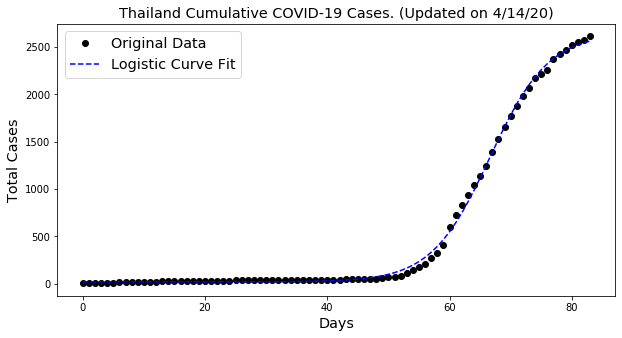



South Africa

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 2415
	Confirmed cases on 4/7/20 	 1749
	Ratio: 1.38
	Weekly increase: 38.1 %
	Daily increase: 4.7 % per day
	Doubling Time (represents recent growth): 15.0 days

** Based on Logistic Fit**

	R^2: 0.9824652505252042
	Doubling Time (during middle of growth):  7.75 (± 1.68 ) days
	param:  [ 7.13289819e+01  1.78802205e-01 -1.06255971e+02  2.28203508e+03]

 exponential R^2  0.8877759992752198


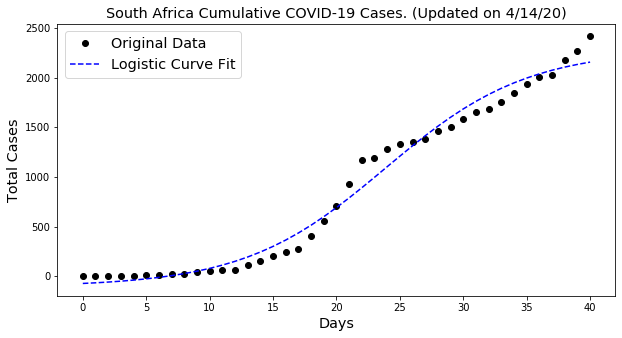



Egypt

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 2350
	Confirmed cases on 4/7/20 	 1450
	Ratio: 1.62
	Weekly increase: 62.1 %
	Daily increase: 7.1 % per day
	Doubling Time (represents recent growth): 10.0 days

** Based on Logistic Fit**

	R^2: 0.9986720450360554
	Doubling Time (during middle of growth):  12.94 (± 0.8 ) days
	param:  [ 8.89177207e+02  1.07117001e-01 -2.28454471e+01  5.78915563e+03]

** Based on Exponential Fit **

	R^2: 0.996947496750098
	Doubling Time (represents overall growth):  8.62 (± 0.29 ) days
	param:  [ 20.15205825   0.08043917 -63.77948859]


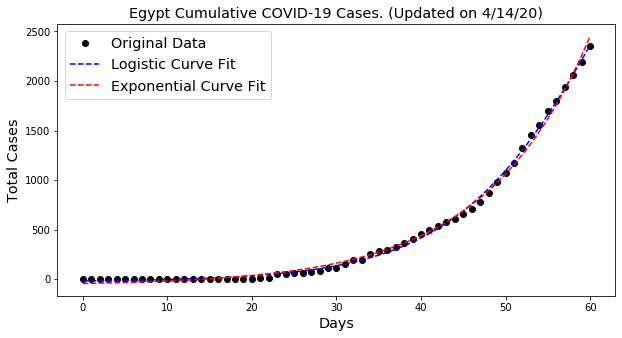



Argentina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 2277
	Confirmed cases on 4/7/20 	 1628
	Ratio: 1.4
	Weekly increase: 39.9 %
	Daily increase: 4.9 % per day
	Doubling Time (represents recent growth): 14.5 days

** Based on Logistic Fit**

	R^2: 0.9972312327361545
	Doubling Time (during middle of growth):  8.27 (± 0.73 ) days
	param:  [ 1.85119210e+02  1.67597185e-01 -4.23856748e+01  2.58973913e+03]

** Based on Exponential Fit **

	R^2: 0.9678487492724395
	Doubling Time (represents overall growth):  8.8 (± 1.47 ) days
	param:  [ 1.00000000e+02  7.87235483e-02 -1.00000000e+02]


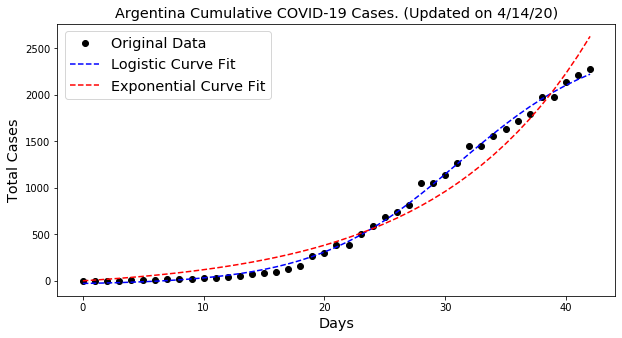



Greece

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 2170
	Confirmed cases on 4/7/20 	 1832
	Ratio: 1.18
	Weekly increase: 18.4 %
	Daily increase: 2.4 % per day
	Doubling Time (represents recent growth): 28.7 days

** Based on Logistic Fit**

	R^2: 0.9989067775215003
	Doubling Time (during middle of growth):  10.21 (± 0.54 ) days
	param:  [ 8.22540484e+01  1.35827566e-01 -5.05023904e+01  2.44711031e+03]

 exponential R^2  0.9363132029864725


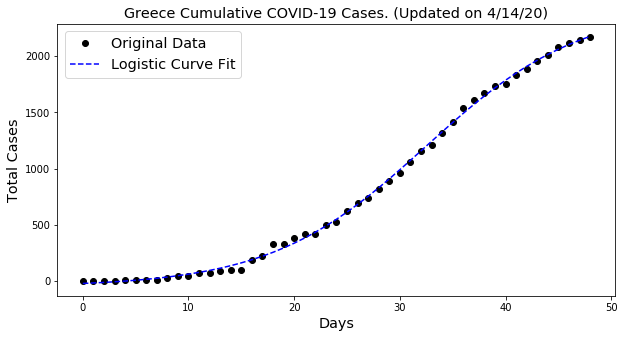



Algeria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 2070
	Confirmed cases on 4/7/20 	 1468
	Ratio: 1.41
	Weekly increase: 41.0 %
	Daily increase: 5.0 % per day
	Doubling Time (represents recent growth): 14.1 days

** Based on Logistic Fit**

	R^2: 0.9983946925780752
	Doubling Time (during middle of growth):  6.87 (± 0.39 ) days
	param:  [2.36157822e+03 2.01698146e-01 1.93580891e+00 2.26147327e+03]

** Based on Exponential Fit **

	R^2: 0.9726198912140471
	Doubling Time (represents overall growth):  8.79 (± 1.14 ) days
	param:  [ 5.14427307e+01  7.88476161e-02 -1.00000000e+02]


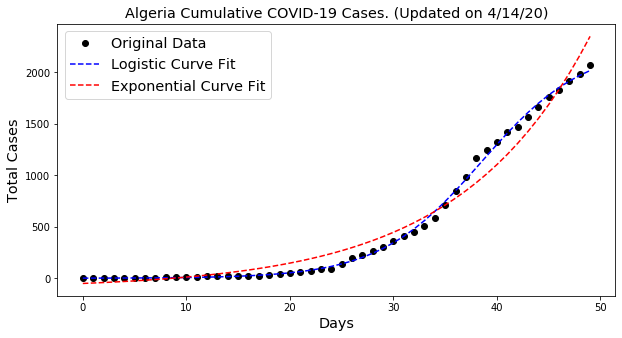



Moldova

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 1934
	Confirmed cases on 4/7/20 	 1056
	Ratio: 1.83
	Weekly increase: 83.1 %
	Daily increase: 9.0 % per day
	Doubling Time (represents recent growth): 8.0 days

** Based on Logistic Fit**

	R^2: 0.9985703518896362
	Doubling Time (during middle of growth):  6.99 (± 0.49 ) days
	param:  [5.42704993e+02 1.98339689e-01 2.97747160e+00 2.54308500e+03]

** Based on Exponential Fit **

	R^2: 0.9893570850796487
	Doubling Time (represents overall growth):  6.97 (± 0.65 ) days
	param:  [ 5.41878728e+01  9.94104363e-02 -1.00000000e+02]


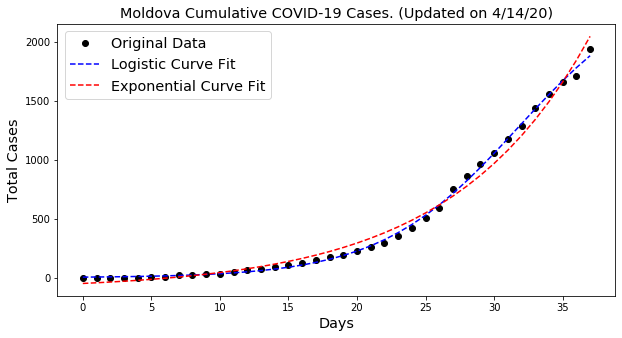



Morocco

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 1888
	Confirmed cases on 4/7/20 	 1184
	Ratio: 1.59
	Weekly increase: 59.5 %
	Daily increase: 6.9 % per day
	Doubling Time (represents recent growth): 10.4 days

** Based on Logistic Fit**

	R^2: 0.9982951189225867
	Doubling Time (during middle of growth):  8.73 (± 0.64 ) days
	param:  [ 3.15413952e+02  1.58741147e-01 -2.92141609e+01  2.46897678e+03]

** Based on Exponential Fit **

	R^2: 0.98725321990277
	Doubling Time (represents overall growth):  8.3 (± 0.81 ) days
	param:  [ 5.87600483e+01  8.34678099e-02 -1.00000000e+02]


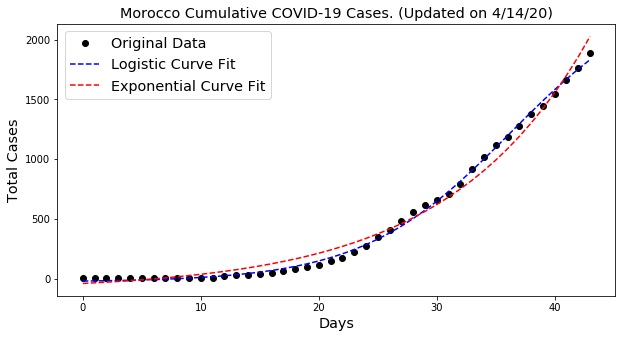



Iceland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 1720
	Confirmed cases on 4/7/20 	 1586
	Ratio: 1.08
	Weekly increase: 8.4 %
	Daily increase: 1.2 % per day
	Doubling Time (represents recent growth): 59.8 days

** Based on Logistic Fit**

	R^2: 0.9991270735707096
	Doubling Time (during middle of growth):  8.15 (± 0.35 ) days
	param:  [ 1.24817966e+02  1.70012849e-01 -1.72201507e+01  1.82801240e+03]

 exponential R^2  0.9075027301188627


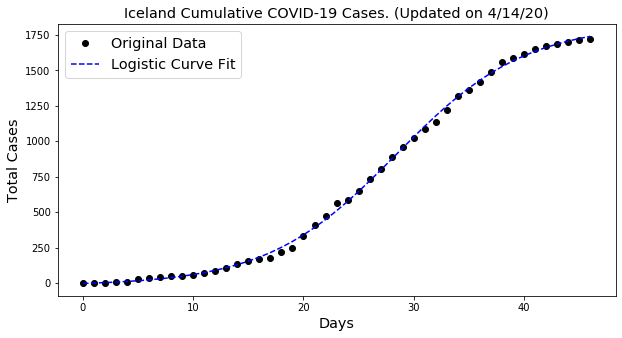



Croatia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 1704
	Confirmed cases on 4/7/20 	 1282
	Ratio: 1.33
	Weekly increase: 32.9 %
	Daily increase: 4.1 % per day
	Doubling Time (represents recent growth): 17.1 days

** Based on Logistic Fit**

	R^2: 0.9968196112509922
	Doubling Time (during middle of growth):  7.99 (± 0.64 ) days
	param:  [ 4.81312064e+02  1.73560675e-01 -2.24690628e+01  1.79371180e+03]

** Based on Exponential Fit **

	R^2: 0.9637298913414182
	Doubling Time (represents overall growth):  10.5 (± 1.77 ) days
	param:  [ 8.05609825e+01  6.60410838e-02 -1.00000000e+02]


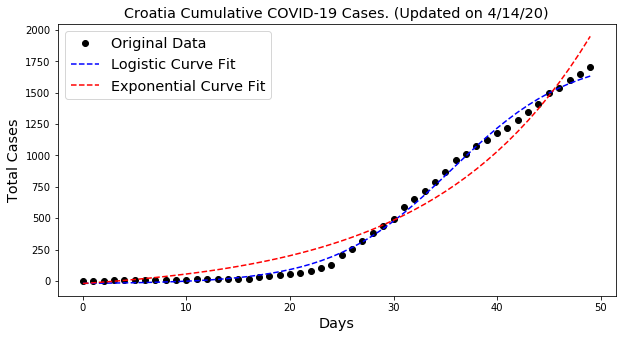



Bahrain

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 1528
	Confirmed cases on 4/7/20 	 811
	Ratio: 1.88
	Weekly increase: 88.4 %
	Daily increase: 9.5 % per day
	Doubling Time (represents recent growth): 7.7 days

** Based on Logistic Fit**

	R^2: 0.9813440551685084
	Doubling Time (during middle of growth):  23.15 (± 3.95 ) days
	param:  [ 2.07061830e+08  5.98728921e-02 -3.78145767e+01  1.41743992e+10]

** Based on Exponential Fit **

	R^2: 0.9813440562196202
	Doubling Time (represents overall growth):  11.58 (± 1.39 ) days
	param:  [ 6.84546526e+01  5.98729647e-02 -3.78140912e+01]


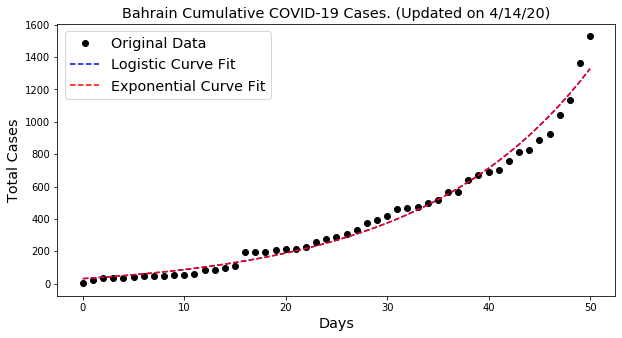



Hungary

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 1512
	Confirmed cases on 4/7/20 	 817
	Ratio: 1.85
	Weekly increase: 85.1 %
	Daily increase: 9.2 % per day
	Doubling Time (represents recent growth): 7.9 days

** Based on Logistic Fit**

	R^2: 0.9943837917903224
	Doubling Time (during middle of growth):  13.31 (± 2.82 ) days
	param:  [ 1.44363518e+02  1.04133715e-01 -5.69067544e+01  4.82347054e+03]

** Based on Exponential Fit **

	R^2: 0.9936180392579639
	Doubling Time (represents overall growth):  8.61 (± 0.63 ) days
	param:  [ 6.25037187e+01  8.05119892e-02 -1.00000000e+02]


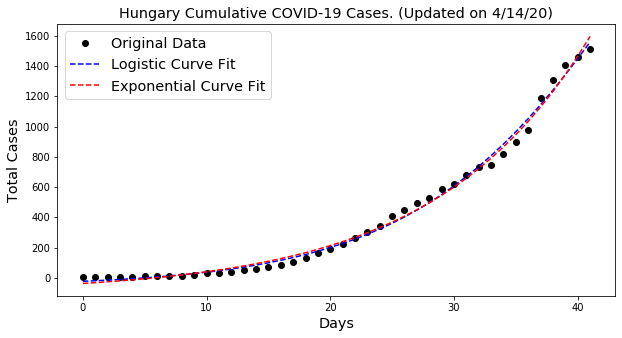



Iraq

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 1400
	Confirmed cases on 4/7/20 	 1122
	Ratio: 1.25
	Weekly increase: 24.8 %
	Daily increase: 3.2 % per day
	Doubling Time (represents recent growth): 21.9 days

** Based on Logistic Fit**

	R^2: 0.9987009245854497
	Doubling Time (during middle of growth):  9.4 (± 0.52 ) days
	param:  [3.26942805e+02 1.47548820e-01 1.20391727e+01 1.72144251e+03]

** Based on Exponential Fit **

	R^2: 0.9826882088941534
	Doubling Time (represents overall growth):  11.21 (± 1.29 ) days
	param:  [ 7.74603214e+01  6.18192188e-02 -1.00000000e+02]


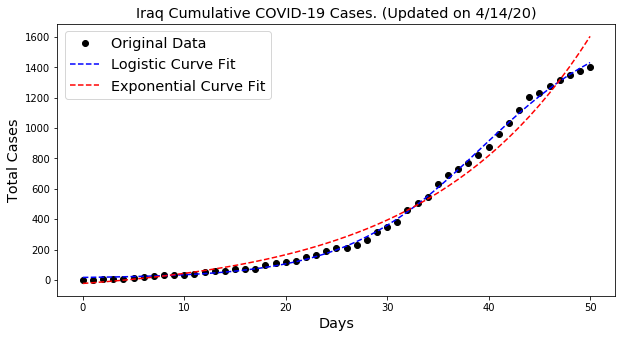



Estonia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 1373
	Confirmed cases on 4/7/20 	 1149
	Ratio: 1.19
	Weekly increase: 19.5 %
	Daily increase: 2.6 % per day
	Doubling Time (represents recent growth): 27.2 days

** Based on Logistic Fit**

	R^2: 0.9960462414814665
	Doubling Time (during middle of growth):  10.13 (± 1.04 ) days
	param:  [ 8.94114360e+01  1.36877012e-01 -3.67247575e+01  1.57926582e+03]

** Based on Exponential Fit **

	R^2: 0.9600656471768901
	Doubling Time (represents overall growth):  11.42 (± 2.2 ) days
	param:  [ 1.00000000e+02  6.06994110e-02 -9.43452478e+01]


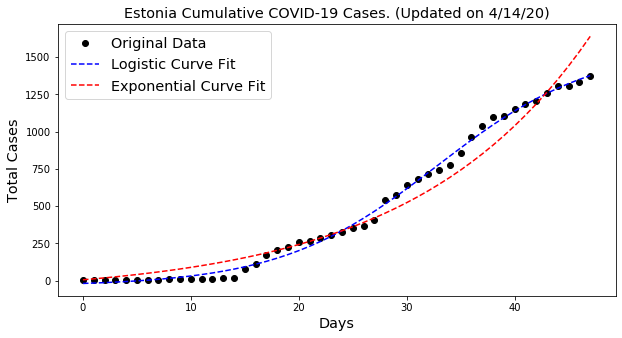



New Zealand

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 1366
	Confirmed cases on 4/7/20 	 1160
	Ratio: 1.18
	Weekly increase: 17.8 %
	Daily increase: 2.4 % per day
	Doubling Time (represents recent growth): 29.7 days

** Based on Logistic Fit**

	R^2: 0.9986507757820529
	Doubling Time (during middle of growth):  5.67 (± 0.29 ) days
	param:  [ 2.95990933e+03  2.44589378e-01 -9.86412954e+00  1.41024853e+03]

 exponential R^2  0.9442784147193211


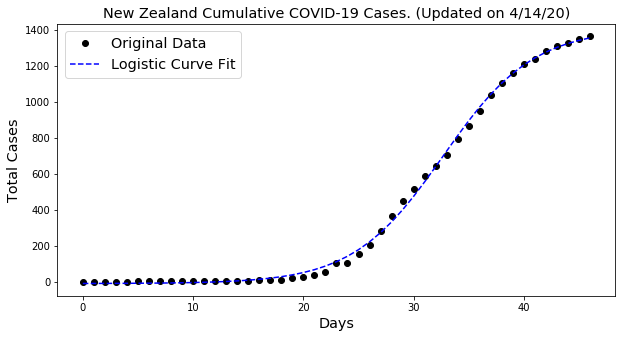



Kuwait

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 1355
	Confirmed cases on 4/7/20 	 743
	Ratio: 1.82
	Weekly increase: 82.4 %
	Daily increase: 9.0 % per day
	Doubling Time (represents recent growth): 8.1 days

** Based on Logistic Fit**

	R^2: 0.9919648214606074
	Doubling Time (during middle of growth):  9.03 (± 1.4 ) days
	param:  [2.50537414e+03 1.53468813e-01 6.10389119e+01 2.99623245e+03]

** Based on Exponential Fit **

	R^2: 0.9900358818420139
	Doubling Time (represents overall growth):  6.36 (± 0.41 ) days
	param:  [ 6.150475    0.10897932 36.23078289]


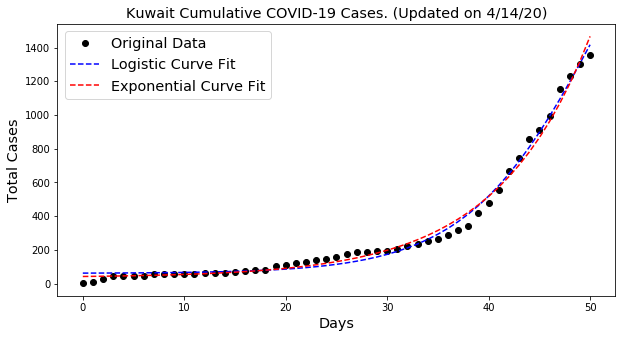



Kazakhstan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 1232
	Confirmed cases on 4/7/20 	 697
	Ratio: 1.77
	Weekly increase: 76.8 %
	Daily increase: 8.5 % per day
	Doubling Time (represents recent growth): 8.5 days

** Based on Logistic Fit**

	R^2: 0.9906258075440073
	Doubling Time (during middle of growth):  11.71 (± 3.99 ) days
	param:  [ 4.27318615e+01  1.18387895e-01 -7.44413795e+01  2.33162922e+03]

** Based on Exponential Fit **

	R^2: 0.9870695361318681
	Doubling Time (represents overall growth):  8.45 (± 1.18 ) days
	param:  [ 9.52095102e+01  8.20303595e-02 -1.00000000e+02]


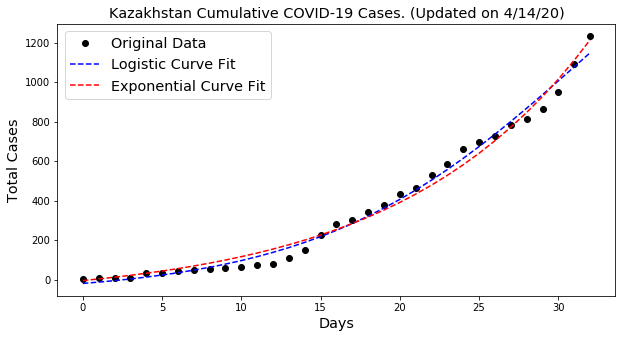



Slovenia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 1220
	Confirmed cases on 4/7/20 	 1059
	Ratio: 1.15
	Weekly increase: 15.2 %
	Daily increase: 2.0 % per day
	Doubling Time (represents recent growth): 34.3 days

** Based on Logistic Fit**

	R^2: 0.9982028908729443
	Doubling Time (during middle of growth):  12.59 (± 1.3 ) days
	param:  [ 1.18441176e+01  1.10093178e-01 -1.39067718e+02  1.43988982e+03]

 exponential R^2  0.90214230025017


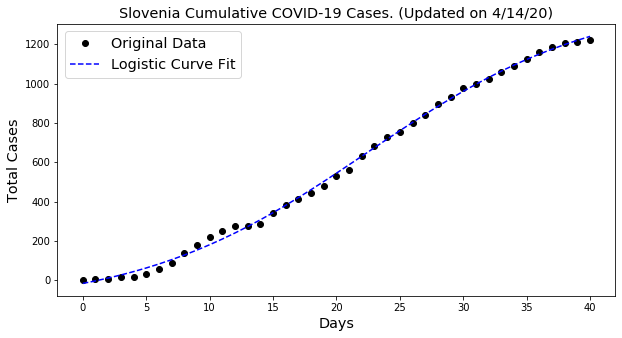



Azerbaijan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 1197
	Confirmed cases on 4/7/20 	 717
	Ratio: 1.67
	Weekly increase: 66.9 %
	Daily increase: 7.6 % per day
	Doubling Time (represents recent growth): 9.5 days

** Based on Logistic Fit**

	R^2: 0.9990936310462154
	Doubling Time (during middle of growth):  6.99 (± 0.34 ) days
	param:  [1.64528370e+03 1.98248150e-01 4.84657300e+00 1.53652921e+03]

** Based on Exponential Fit **

	R^2: 0.9851445839036248
	Doubling Time (represents overall growth):  7.51 (± 0.72 ) days
	param:  [ 24.1305297    0.09225729 -61.78561978]


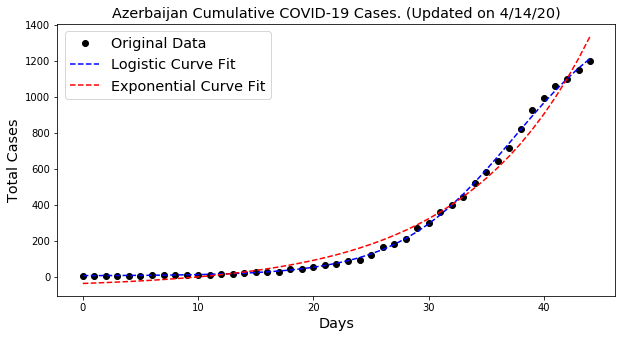



Uzbekistan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 1165
	Confirmed cases on 4/7/20 	 520
	Ratio: 2.24
	Weekly increase: 124.0 %
	Daily increase: 12.2 % per day
	Doubling Time (represents recent growth): 6.0 days

** Based on Logistic Fit**

	R^2: 0.9947159865129583
	Doubling Time (during middle of growth):  10.76 (± 3.09 ) days
	param:  [ 1.14813140e+06  1.28894689e-01 -2.17058722e+01  2.80556020e+07]

** Based on Exponential Fit **

	R^2: 0.9947159869192831
	Doubling Time (represents overall growth):  5.38 (± 0.38 ) days
	param:  [ 24.43760307   0.12889115 -21.70869249]


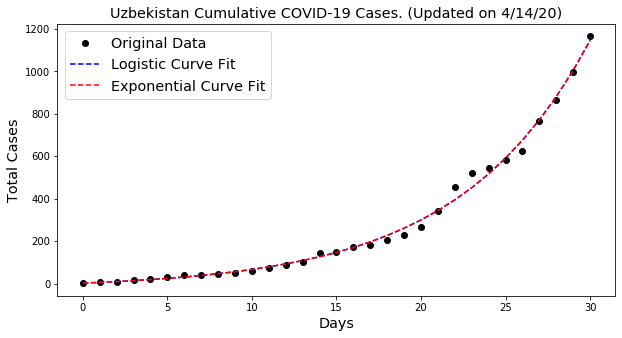



Bosnia and Herzegovina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 1083
	Confirmed cases on 4/7/20 	 764
	Ratio: 1.42
	Weekly increase: 41.8 %
	Daily increase: 5.1 % per day
	Doubling Time (represents recent growth): 13.9 days

** Based on Logistic Fit**

	R^2: 0.9986201757720559
	Doubling Time (during middle of growth):  8.66 (± 0.59 ) days
	param:  [ 1.37639348e+02  1.60008288e-01 -1.86478960e+01  1.31591802e+03]

** Based on Exponential Fit **

	R^2: 0.9836441783400409
	Doubling Time (represents overall growth):  9.88 (± 1.32 ) days
	param:  [ 7.82932896e+01  7.01901708e-02 -1.00000000e+02]


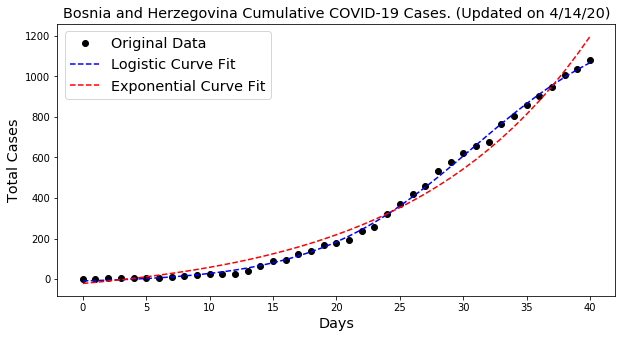



Lithuania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 1070
	Confirmed cases on 4/7/20 	 880
	Ratio: 1.22
	Weekly increase: 21.6 %
	Daily increase: 2.8 % per day
	Doubling Time (represents recent growth): 24.8 days

** Based on Logistic Fit**

	R^2: 0.9979342119090322
	Doubling Time (during middle of growth):  6.94 (± 0.45 ) days
	param:  [ 6.34172248e+02  1.99827483e-01 -1.61894562e+01  1.13612838e+03]

** Based on Exponential Fit **

	R^2: 0.9563522202843828
	Doubling Time (represents overall growth):  10.75 (± 2.17 ) days
	param:  [ 7.12698419e+01  6.44913609e-02 -1.00000000e+02]


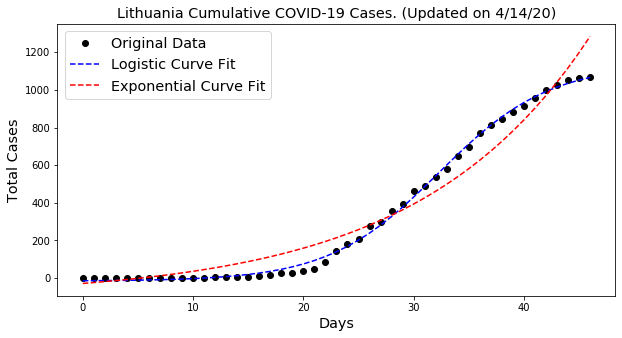



Armenia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 1067
	Confirmed cases on 4/7/20 	 853
	Ratio: 1.25
	Weekly increase: 25.1 %
	Daily increase: 3.2 % per day
	Doubling Time (represents recent growth): 21.7 days

** Based on Logistic Fit**

	R^2: 0.9978275670405041
	Doubling Time (during middle of growth):  7.9 (± 0.56 ) days
	param:  [ 2.03367965e+02  1.75412156e-01 -1.68319546e+01  1.14054202e+03]

** Based on Exponential Fit **

	R^2: 0.9622298883326768
	Doubling Time (represents overall growth):  11.35 (± 2.34 ) days
	param:  [ 9.10426458e+01  6.10615096e-02 -1.00000000e+02]


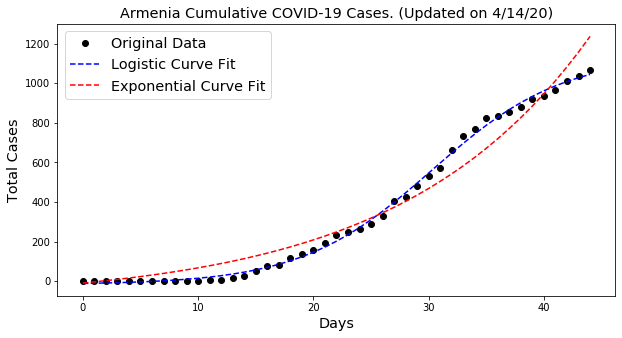



Bangladesh

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 1012
	Confirmed cases on 4/7/20 	 164
	Ratio: 6.17
	Weekly increase: 517.1 %
	Daily increase: 29.7 % per day
	Doubling Time (represents recent growth): 2.7 days

** Based on Logistic Fit**

	R^2: 0.9829620956314807
	Doubling Time (during middle of growth):  6.04 (± 1.68 ) days
	param:  [ 1.73797046e+04  2.29575657e-01 -4.70347238e-05  4.23771788e+03]

** Based on Exponential Fit **

	R^2: 0.9949693088720664
	Doubling Time (represents overall growth):  2.74 (± 0.14 ) days
	param:  [ 0.08608236  0.25321622 14.2773744 ]


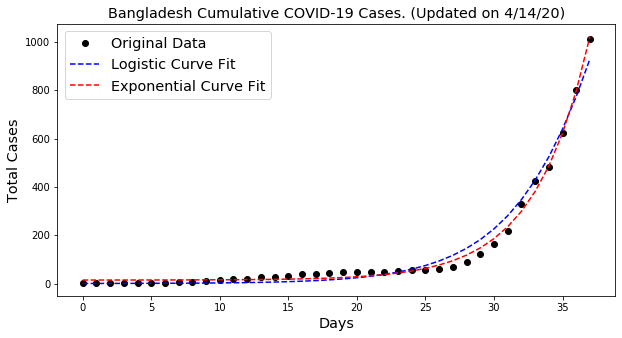



North Macedonia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 908
	Confirmed cases on 4/7/20 	 599
	Ratio: 1.52
	Weekly increase: 51.6 %
	Daily increase: 6.1 % per day
	Doubling Time (represents recent growth): 11.7 days

** Based on Logistic Fit**

	R^2: 0.9974325809706374
	Doubling Time (during middle of growth):  10.1 (± 0.88 ) days
	param:  [ 2.89270548e+02  1.37247344e-01 -1.61163540e+01  1.24663521e+03]

** Based on Exponential Fit **

	R^2: 0.9893236351599866
	Doubling Time (represents overall growth):  9.95 (± 0.86 ) days
	param:  [ 3.66710291e+01  6.96500886e-02 -7.61811193e+01]


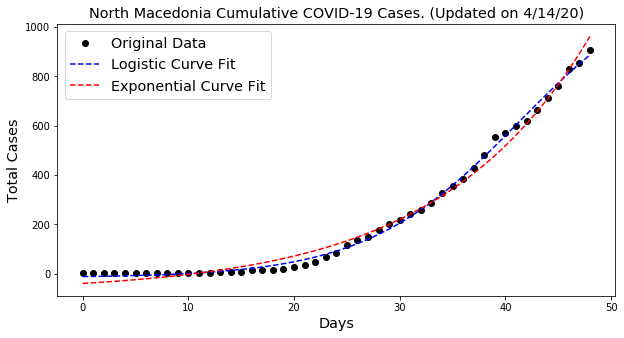



Cameroon

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 848
	Confirmed cases on 4/7/20 	 658
	Ratio: 1.29
	Weekly increase: 28.9 %
	Daily increase: 3.7 % per day
	Doubling Time (represents recent growth): 19.1 days

** Based on Logistic Fit**

	R^2: 0.9928390561922098
	Doubling Time (during middle of growth):  3.49 (± 0.45 ) days
	param:  [6.19699755e+04 3.96818700e-01 1.36137982e+01 8.39726399e+02]

 exponential R^2  0.9317292444398406


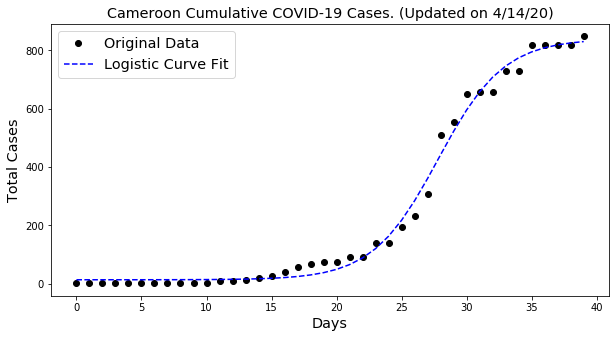



Slovakia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 835
	Confirmed cases on 4/7/20 	 581
	Ratio: 1.44
	Weekly increase: 43.7 %
	Daily increase: 5.3 % per day
	Doubling Time (represents recent growth): 13.4 days

** Based on Logistic Fit**

	R^2: 0.9952380032394798
	Doubling Time (during middle of growth):  15.9 (± 3.92 ) days
	param:  [ 2.25653261e+01  8.72090273e-02 -8.07009265e+01  1.51671213e+03]

** Based on Exponential Fit **

	R^2: 0.9871325784200373
	Doubling Time (represents overall growth):  11.79 (± 1.63 ) days
	param:  [ 1.00000000e+02  5.87974386e-02 -9.34219690e+01]


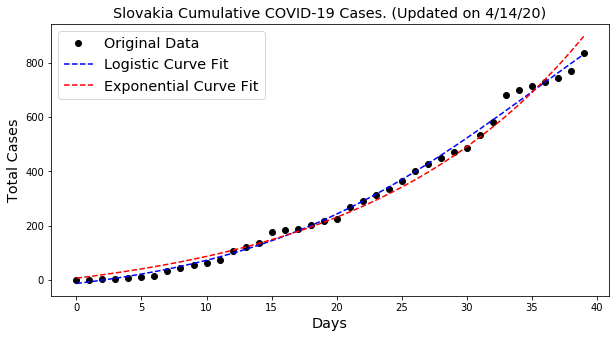



Oman

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 813
	Confirmed cases on 4/7/20 	 371
	Ratio: 2.19
	Weekly increase: 119.1 %
	Daily increase: 11.9 % per day
	Doubling Time (represents recent growth): 6.2 days

** Based on Logistic Fit**

	R^2: 0.9963154712500474
	Doubling Time (during middle of growth):  13.29 (± 1.05 ) days
	param:  [ 9.09393593e+08  1.04276964e-01 -2.63891257e+00  3.87564764e+09]

** Based on Exponential Fit **

	R^2: 0.9963154719547929
	Doubling Time (represents overall growth):  6.65 (± 0.27 ) days
	param:  [ 4.26179554  0.10427696 -2.63891933]


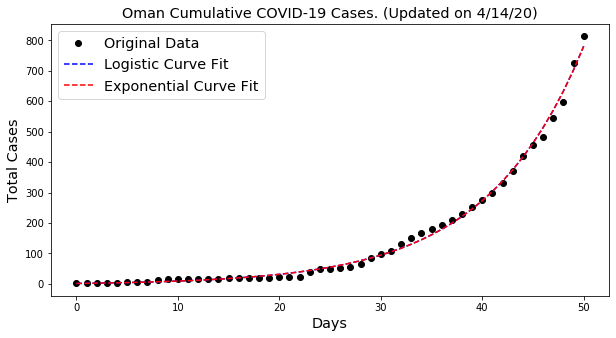



Cuba

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 766
	Confirmed cases on 4/7/20 	 396
	Ratio: 1.93
	Weekly increase: 93.4 %
	Daily increase: 9.9 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.9982897049447451
	Doubling Time (during middle of growth):  9.64 (± 1.09 ) days
	param:  [ 1.05226493e+02  1.43866412e-01 -2.18191978e+01  1.50196811e+03]

** Based on Exponential Fit **

	R^2: 0.9957677088888963
	Doubling Time (represents overall growth):  7.77 (± 0.55 ) days
	param:  [ 46.02311508   0.08922108 -68.96773834]


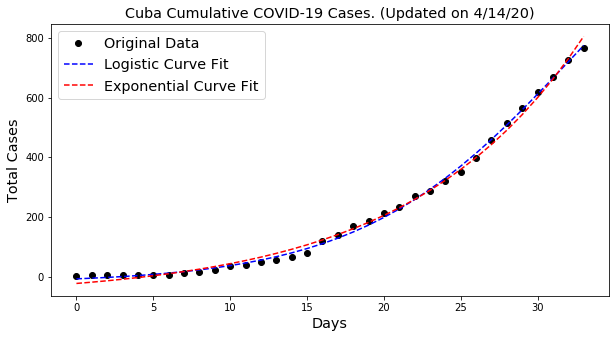



Tunisia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 747
	Confirmed cases on 4/7/20 	 623
	Ratio: 1.2
	Weekly increase: 19.9 %
	Daily increase: 2.6 % per day
	Doubling Time (represents recent growth): 26.7 days

** Based on Logistic Fit**

	R^2: 0.998259151002829
	Doubling Time (during middle of growth):  6.23 (± 0.39 ) days
	param:  [ 3.91305034e+02  2.22362648e-01 -5.07083777e+00  7.52015504e+02]

** Based on Exponential Fit **

	R^2: 0.9522747431924736
	Doubling Time (represents overall growth):  11.61 (± 2.99 ) days
	param:  [ 8.42830812e+01  5.97031233e-02 -1.00000000e+02]


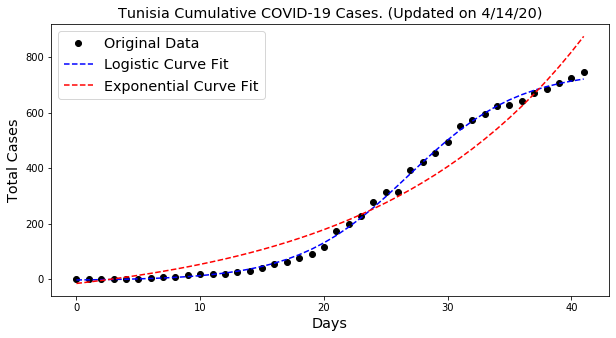



Afghanistan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 714
	Confirmed cases on 4/7/20 	 423
	Ratio: 1.69
	Weekly increase: 68.8 %
	Daily increase: 7.8 % per day
	Doubling Time (represents recent growth): 9.3 days

** Based on Logistic Fit**

	R^2: 0.9972962595172166
	Doubling Time (during middle of growth):  8.86 (± 0.74 ) days
	param:  [ 1.27438629e+03  1.56540033e-01 -4.13709172e+00  1.04760663e+03]

** Based on Exponential Fit **

	R^2: 0.9905045778132892
	Doubling Time (represents overall growth):  7.6 (± 0.52 ) days
	param:  [  8.10545259   0.09122574 -26.83308895]


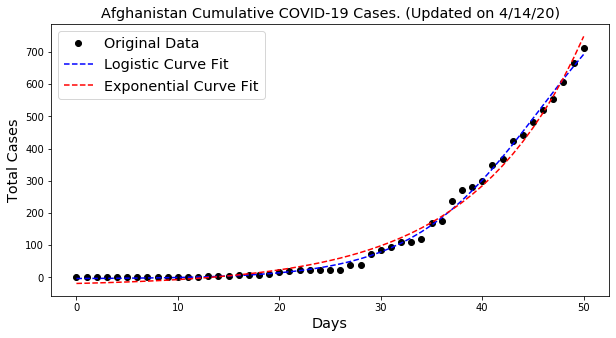



Bulgaria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 713
	Confirmed cases on 4/7/20 	 577
	Ratio: 1.24
	Weekly increase: 23.6 %
	Daily increase: 3.1 % per day
	Doubling Time (represents recent growth): 22.9 days

** Based on Logistic Fit**

	R^2: 0.9988664292709033
	Doubling Time (during middle of growth):  11.4 (± 0.95 ) days
	param:  [ 1.52224762e+01  1.21645072e-01 -6.84951551e+01  8.33390588e+02]

** Based on Exponential Fit **

	R^2: 0.9510676613148652
	Doubling Time (represents overall growth):  11.76 (± 3.5 ) days
	param:  [ 1.00000000e+02  5.89199314e-02 -5.61485076e+01]


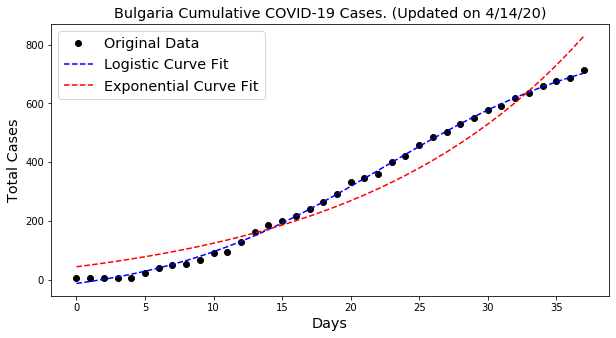



Diamond Princess

** Based on Logistic Fit**

	R^2: 0.9963587194157362
	Doubling Time (during middle of growth):  2.83 (± 0.21 ) days
	param:  [8.91046346e+01 4.90149822e-01 6.84643474e+01 7.08981849e+02]

 exponential R^2  -0.7464529793013726


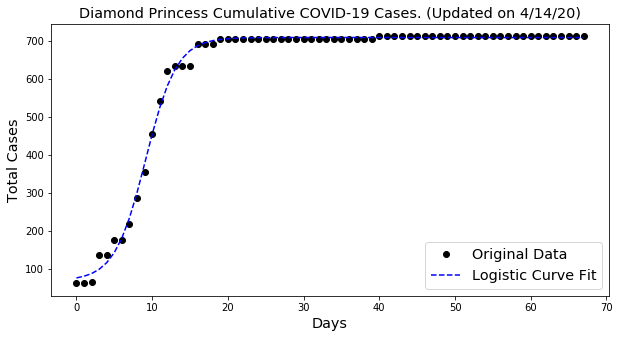



Cyprus

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 695
	Confirmed cases on 4/7/20 	 494
	Ratio: 1.41
	Weekly increase: 40.7 %
	Daily increase: 5.0 % per day
	Doubling Time (represents recent growth): 14.2 days

** Based on Logistic Fit**

	R^2: 0.997893951334059
	Doubling Time (during middle of growth):  8.85 (± 0.85 ) days
	param:  [ 6.07767352e+01  1.56598150e-01 -7.07394537e+00  8.34598092e+02]

** Based on Exponential Fit **

	R^2: 0.9847939841481878
	Doubling Time (represents overall growth):  11.44 (± 1.88 ) days
	param:  [ 9.70702917e+01  6.05799534e-02 -1.00000000e+02]


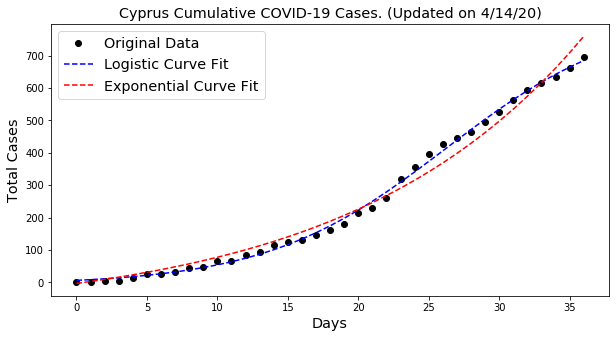



Andorra

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 659
	Confirmed cases on 4/7/20 	 545
	Ratio: 1.21
	Weekly increase: 20.9 %
	Daily increase: 2.8 % per day
	Doubling Time (represents recent growth): 25.5 days

** Based on Logistic Fit**

	R^2: 0.9962215540540748
	Doubling Time (during middle of growth):  7.43 (± 0.69 ) days
	param:  [ 1.71939038e+02  1.86521515e-01 -1.84247717e+01  6.74275575e+02]

** Based on Exponential Fit **

	R^2: 0.9544690380191909
	Doubling Time (represents overall growth):  12.8 (± 3.26 ) days
	param:  [ 8.49068066e+01  5.41383923e-02 -1.00000000e+02]


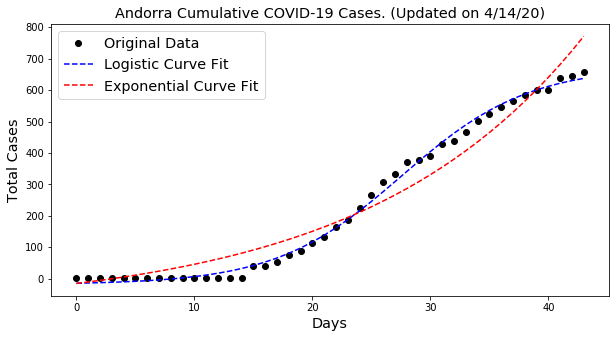



Latvia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 657
	Confirmed cases on 4/7/20 	 548
	Ratio: 1.2
	Weekly increase: 19.9 %
	Daily increase: 2.6 % per day
	Doubling Time (represents recent growth): 26.7 days

** Based on Logistic Fit**

	R^2: 0.9987900796045822
	Doubling Time (during middle of growth):  7.75 (± 0.41 ) days
	param:  [ 1.22725952e+02  1.78894460e-01 -1.45694503e+01  6.86788736e+02]

** Based on Exponential Fit **

	R^2: 0.9539976804323848
	Doubling Time (represents overall growth):  13.52 (± 3.63 ) days
	param:  [ 9.74265159e+01  5.12737225e-02 -1.00000000e+02]


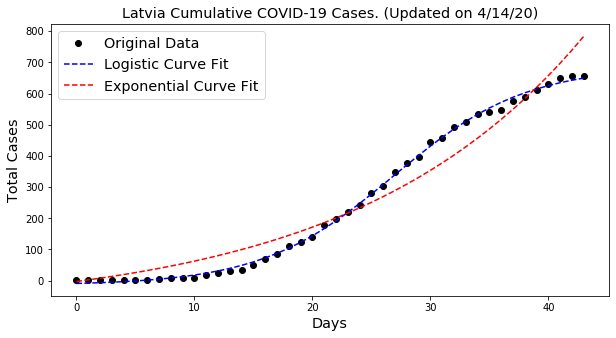



Lebanon

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 641
	Confirmed cases on 4/7/20 	 548
	Ratio: 1.17
	Weekly increase: 17.0 %
	Daily increase: 2.3 % per day
	Doubling Time (represents recent growth): 31.0 days

** Based on Logistic Fit**

	R^2: 0.9968604545874437
	Doubling Time (during middle of growth):  8.4 (± 0.61 ) days
	param:  [ 2.32196255e+02  1.65060101e-01 -5.35785198e+00  6.42173143e+02]

 exponential R^2  0.9490561744903583


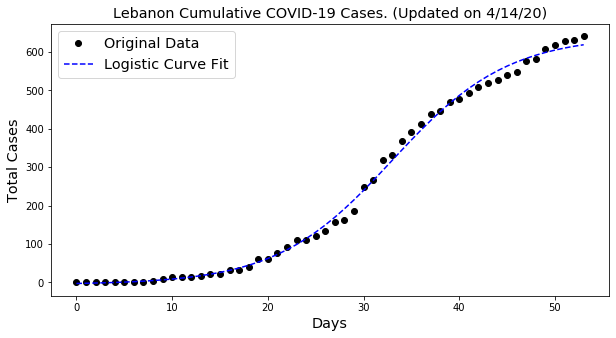



Cote d'Ivoire

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 638
	Confirmed cases on 4/7/20 	 349
	Ratio: 1.83
	Weekly increase: 82.8 %
	Daily increase: 9.0 % per day
	Doubling Time (represents recent growth): 8.0 days

** Based on Logistic Fit**

	R^2: 0.9932697680017728
	Doubling Time (during middle of growth):  12.34 (± 3.54 ) days
	param:  [ 8.75976286e+01  1.12320585e-01 -3.59663648e+01  1.99594894e+03]

** Based on Exponential Fit **

	R^2: 0.992560189742404
	Doubling Time (represents overall growth):  8.29 (± 0.79 ) days
	param:  [ 42.91040112   0.08358357 -63.1411035 ]


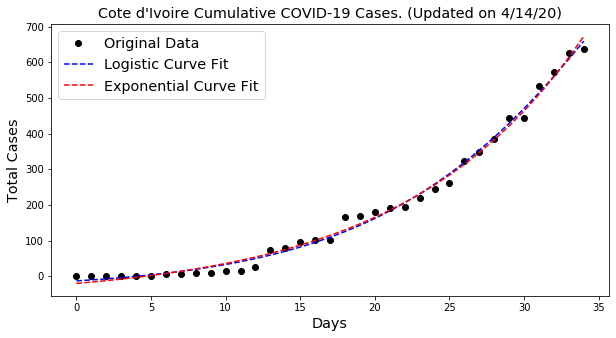



Ghana

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 636
	Confirmed cases on 4/7/20 	 287
	Ratio: 2.22
	Weekly increase: 121.6 %
	Daily increase: 12.0 % per day
	Doubling Time (represents recent growth): 6.1 days

** Based on Logistic Fit**

	R^2: 0.9717901862164777
	Doubling Time (during middle of growth):  14.76 (± nan ) days
	param:  [ 2.26878898e+08  9.38916510e-02 -2.80410833e+01  7.93391851e+09]

** Based on Exponential Fit **

	R^2: 0.97179018703013
	Doubling Time (represents overall growth):  7.38 (± 1.43 ) days
	param:  [ 34.96960763   0.09389186 -28.04066263]


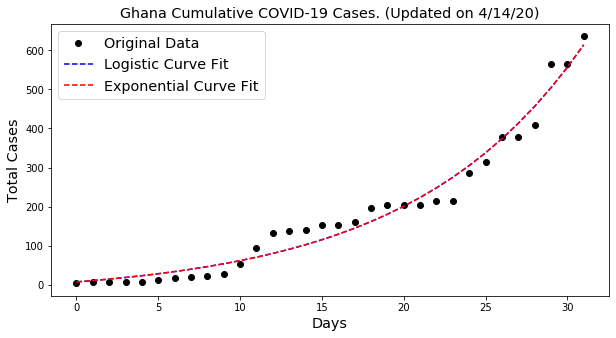



Costa Rica

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 618
	Confirmed cases on 4/7/20 	 483
	Ratio: 1.28
	Weekly increase: 28.0 %
	Daily increase: 3.6 % per day
	Doubling Time (represents recent growth): 19.7 days

** Based on Logistic Fit**

	R^2: 0.9965406281187845
	Doubling Time (during middle of growth):  9.67 (± 1.11 ) days
	param:  [ 3.20473478e+01  1.43414987e-01 -3.33534258e+01  6.82245625e+02]

** Based on Exponential Fit **

	R^2: 0.9621927210625949
	Doubling Time (represents overall growth):  12.93 (± 3.36 ) days
	param:  [ 1.00000000e+02  5.36129417e-02 -9.18091067e+01]


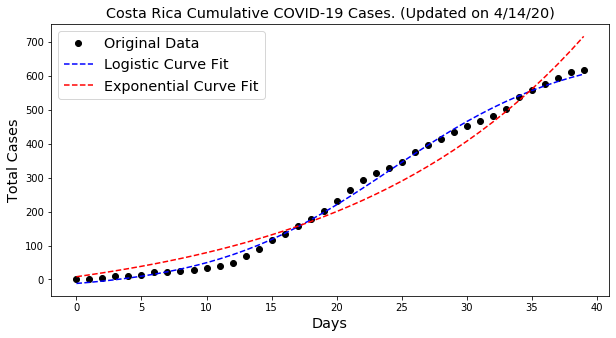



Niger

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 570
	Confirmed cases on 4/7/20 	 278
	Ratio: 2.05
	Weekly increase: 105.0 %
	Daily increase: 10.8 % per day
	Doubling Time (represents recent growth): 6.8 days

** Based on Logistic Fit**

	R^2: 0.9981513262499975
	Doubling Time (during middle of growth):  4.02 (± 0.35 ) days
	param:  [ 5.54104643e+02  3.44797417e-01 -1.61394283e+00  6.22247477e+02]

** Based on Exponential Fit **

	R^2: 0.970901016974626
	Doubling Time (represents overall growth):  6.9 (± 1.68 ) days
	param:  [ 59.38201852   0.10052679 -97.07047124]


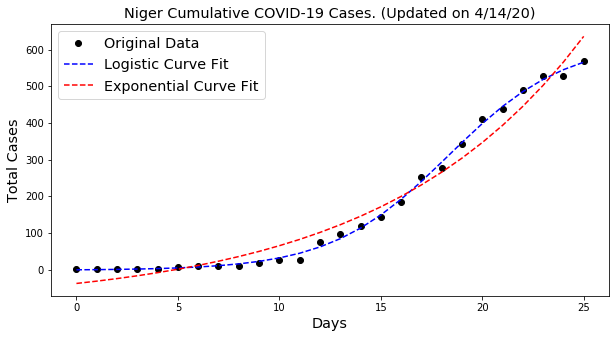



Burkina Faso

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 528
	Confirmed cases on 4/7/20 	 384
	Ratio: 1.38
	Weekly increase: 37.5 %
	Daily increase: 4.7 % per day
	Doubling Time (represents recent growth): 15.2 days

** Based on Logistic Fit**

	R^2: 0.9952178285432809
	Doubling Time (during middle of growth):  11.35 (± 2.14 ) days
	param:  [ 1.72256471e+01  1.22092367e-01 -5.73757001e+01  6.54748806e+02]

** Based on Exponential Fit **

	R^2: 0.9739871706175162
	Doubling Time (represents overall growth):  12.59 (± 3.04 ) days
	param:  [ 1.00000000e+02  5.50404637e-02 -9.89300800e+01]


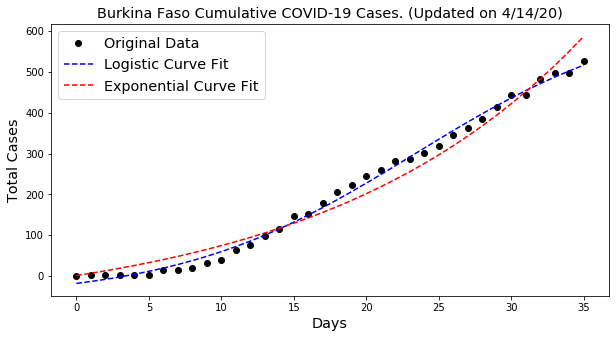



Uruguay

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 483
	Confirmed cases on 4/7/20 	 424
	Ratio: 1.14
	Weekly increase: 13.9 %
	Daily increase: 1.9 % per day
	Doubling Time (represents recent growth): 37.2 days

** Based on Logistic Fit**

	R^2: 0.9955305467573157
	Doubling Time (during middle of growth):  11.08 (± 2.42 ) days
	param:  [ 3.78256167e+00  1.25095884e-01 -1.56548132e+02  5.41159879e+02]

 exponential R^2  0.8760416226603147


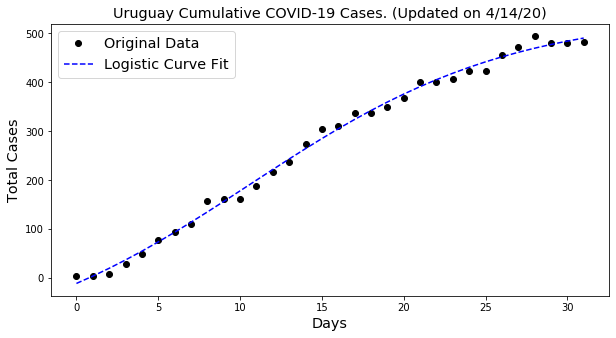



Albania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 475
	Confirmed cases on 4/7/20 	 383
	Ratio: 1.24
	Weekly increase: 24.0 %
	Daily increase: 3.1 % per day
	Doubling Time (represents recent growth): 22.5 days

** Based on Logistic Fit**

	R^2: 0.9975451860400095
	Doubling Time (during middle of growth):  9.75 (± 1.07 ) days
	param:  [ 2.62043109e+01  1.42232222e-01 -9.52598974e+00  5.46617381e+02]

** Based on Exponential Fit **

	R^2: 0.9742749424285937
	Doubling Time (represents overall growth):  13.68 (± 3.39 ) days
	param:  [ 1.00000000e+02  5.06705859e-02 -8.23632013e+01]


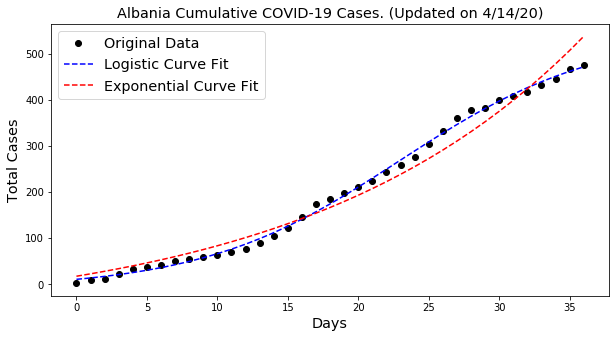



Kyrgyzstan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 430
	Confirmed cases on 4/7/20 	 228
	Ratio: 1.89
	Weekly increase: 88.6 %
	Daily increase: 9.5 % per day
	Doubling Time (represents recent growth): 7.6 days

** Based on Logistic Fit**

	R^2: 0.9931583565932729
	Doubling Time (during middle of growth):  11.41 (± 4.48 ) days
	param:  [ 5.09933840e+01  1.21446182e-01 -2.26048070e+01  1.33736531e+03]

** Based on Exponential Fit **

	R^2: 0.9926719848440745
	Doubling Time (represents overall growth):  7.97 (± 0.98 ) days
	param:  [ 47.67937153   0.08694938 -49.01369056]


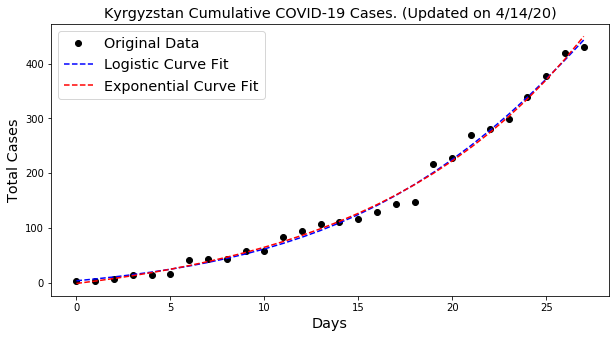



Honduras

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 407
	Confirmed cases on 4/7/20 	 305
	Ratio: 1.33
	Weekly increase: 33.4 %
	Daily increase: 4.2 % per day
	Doubling Time (represents recent growth): 16.8 days

** Based on Logistic Fit**

	R^2: 0.996496809604882
	Doubling Time (during middle of growth):  5.98 (± 0.61 ) days
	param:  [ 1.93017966e+02  2.31664915e-01 -2.22897256e+00  4.35903267e+02]

** Based on Exponential Fit **

	R^2: 0.9682582645435142
	Doubling Time (represents overall growth):  11.88 (± 3.14 ) days
	param:  [ 7.81426920e+01  5.83450667e-02 -1.00000000e+02]


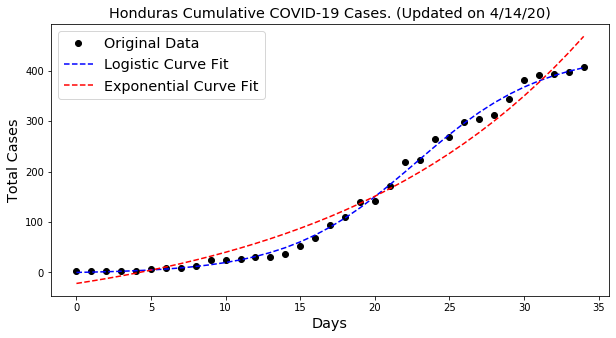



Jordan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 397
	Confirmed cases on 4/7/20 	 353
	Ratio: 1.12
	Weekly increase: 12.5 %
	Daily increase: 1.7 % per day
	Doubling Time (represents recent growth): 41.3 days

** Based on Logistic Fit**

	R^2: 0.994912499578583
	Doubling Time (during middle of growth):  6.77 (± 0.71 ) days
	param:  [ 1.08467918e+02  2.04814884e-01 -1.42835782e+01  3.90097945e+02]

 exponential R^2  0.927687830532034


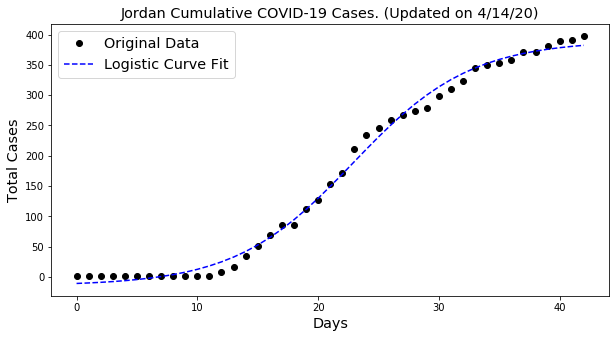



Malta

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 393
	Confirmed cases on 4/7/20 	 293
	Ratio: 1.34
	Weekly increase: 34.1 %
	Daily increase: 4.3 % per day
	Doubling Time (represents recent growth): 16.5 days

** Based on Logistic Fit**

	R^2: 0.991013008683262
	Doubling Time (during middle of growth):  23.55 (± 15.69 ) days
	param:  [ 2.41849733e+01  5.88734507e-02 -7.81439196e+01  1.67557296e+03]

** Based on Exponential Fit **

	R^2: 0.9906791397621368
	Doubling Time (represents overall growth):  15.26 (± 2.28 ) days
	param:  [ 9.22264052e+01  4.54259769e-02 -1.00000000e+02]


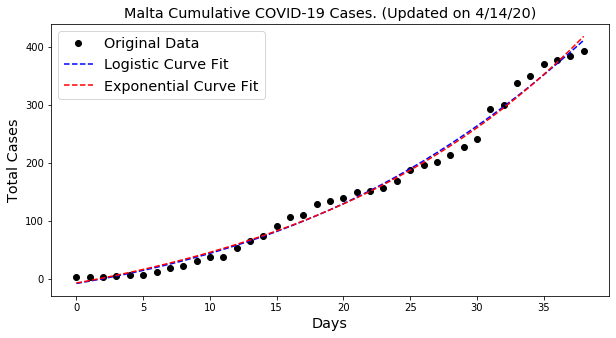



Taiwan*

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 393
	Confirmed cases on 4/7/20 	 376
	Ratio: 1.05
	Weekly increase: 4.5 %
	Daily increase: 0.6 % per day
	Doubling Time (represents recent growth): 109.7 days

** Based on Logistic Fit**

	R^2: 0.9955640282898877
	Doubling Time (during middle of growth):  6.84 (± 0.47 ) days
	param:  [2.85807609e+05 2.02653269e-01 1.91534960e+01 3.95566436e+02]

 exponential R^2  0.9408350595792844


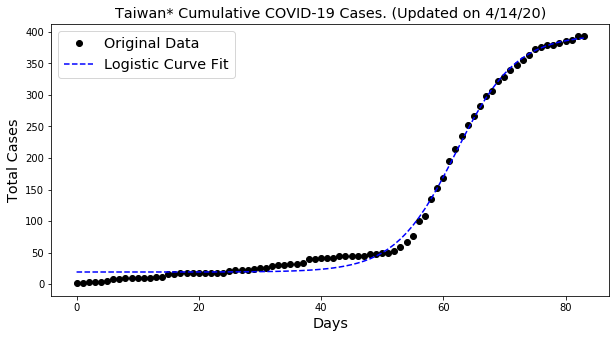



Kosovo

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 387
	Confirmed cases on 4/7/20 	 170
	Ratio: 2.28
	Weekly increase: 127.6 %
	Daily increase: 12.5 % per day
	Doubling Time (represents recent growth): 5.9 days

** Based on Logistic Fit**

	R^2: 0.9674362854741307
	Doubling Time (during middle of growth):  9.21 (± nan ) days
	param:  [6.20886513e+07 1.50501766e-01 6.76958042e+01 1.05562415e+09]

** Based on Exponential Fit **

	R^2: 0.9674362865666942
	Doubling Time (represents overall growth):  4.61 (± 1.26 ) days
	param:  [17.00191972  0.15050165 67.69574497]


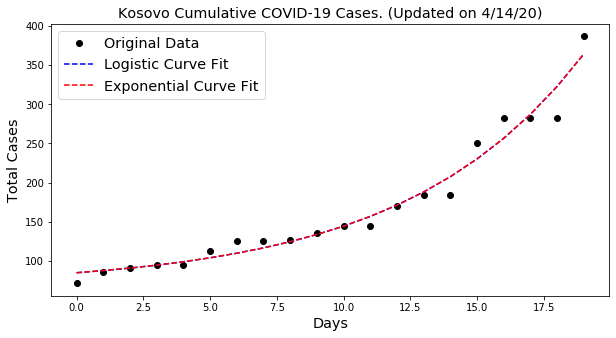



Nigeria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 373
	Confirmed cases on 4/7/20 	 254
	Ratio: 1.47
	Weekly increase: 46.9 %
	Daily increase: 5.6 % per day
	Doubling Time (represents recent growth): 12.6 days

** Based on Logistic Fit**

	R^2: 0.9963303241728164
	Doubling Time (during middle of growth):  7.11 (± 0.63 ) days
	param:  [ 8.95652845e+02  1.94968450e-01 -3.68078135e+00  3.87773208e+02]

** Based on Exponential Fit **

	R^2: 0.9726263560703573
	Doubling Time (represents overall growth):  10.41 (± 1.57 ) days
	param:  [ 20.75368875   0.06655921 -42.70598116]


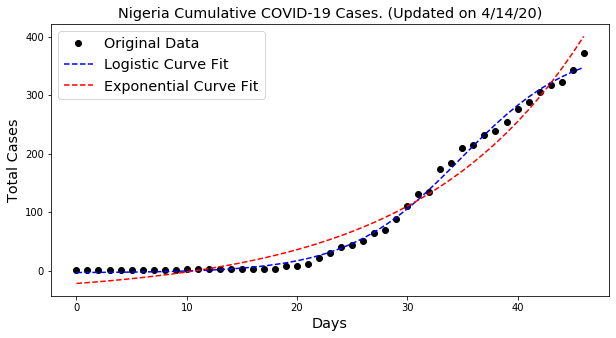



San Marino

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 371
	Confirmed cases on 4/7/20 	 279
	Ratio: 1.33
	Weekly increase: 33.0 %
	Daily increase: 4.2 % per day
	Doubling Time (represents recent growth): 17.0 days

** Based on Logistic Fit**

	R^2: 0.9866599188249895
	Doubling Time (during middle of growth):  29.11 (± 20.5 ) days
	param:  [ 4.77771810e+00  4.76170687e-02 -1.49719178e+02  6.21987173e+02]

** Based on Exponential Fit **

	R^2: 0.964845653579466
	Doubling Time (represents overall growth):  20.58 (± 5.93 ) days
	param:  [ 1.00000000e+02  3.36739914e-02 -8.59586081e+01]


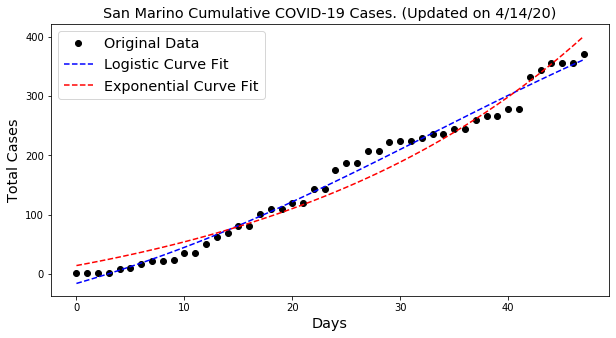



Guinea

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 363
	Confirmed cases on 4/7/20 	 144
	Ratio: 2.52
	Weekly increase: 152.1 %
	Daily increase: 14.1 % per day
	Doubling Time (represents recent growth): 5.2 days

** Based on Logistic Fit**

	R^2: 0.9895218582620996
	Doubling Time (during middle of growth):  6.85 (± 1.6 ) days
	param:  [ 5.29610982e+02  2.02394494e-01 -5.71258609e+00  6.33884662e+02]

** Based on Exponential Fit **

	R^2: 0.9858662687432304
	Doubling Time (represents overall growth):  5.22 (± 0.56 ) days
	param:  [  5.45400356   0.13274376 -15.62507784]


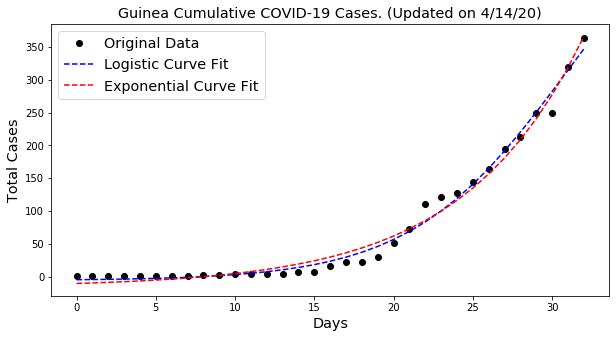



Djibouti

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 363
	Confirmed cases on 4/7/20 	 90
	Ratio: 4.03
	Weekly increase: 303.3 %
	Daily increase: 22.0 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Logistic Fit**

	R^2: 0.9914581080601926
	Doubling Time (during middle of growth):  7.23 (± 0.72 ) days
	param:  [4.53062855e+09 1.91649912e-01 7.42292051e-01 8.97214894e+09]

** Based on Exponential Fit **

	R^2: 0.9914581083740676
	Doubling Time (represents overall growth):  3.62 (± 0.31 ) days
	param:  [1.98033788 0.1916498  0.74226697]


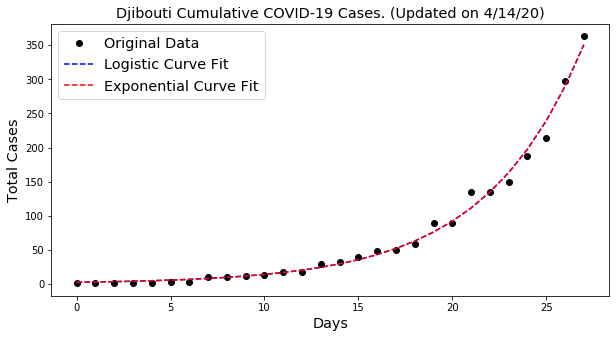



Bolivia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 354
	Confirmed cases on 4/7/20 	 194
	Ratio: 1.82
	Weekly increase: 82.5 %
	Daily increase: 9.0 % per day
	Doubling Time (represents recent growth): 8.1 days

** Based on Logistic Fit**

	R^2: 0.9950458446937384
	Doubling Time (during middle of growth):  11.03 (± 2.33 ) days
	param:  [ 7.22977690e+01  1.25683642e-01 -1.04398639e+01  7.15744952e+02]

** Based on Exponential Fit **

	R^2: 0.9931754945902815
	Doubling Time (represents overall growth):  8.83 (± 0.84 ) days
	param:  [ 27.57367013   0.07850673 -34.44872438]


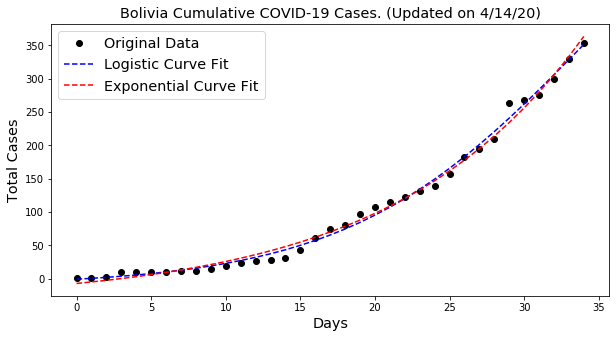



Mauritius

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 324
	Confirmed cases on 4/7/20 	 268
	Ratio: 1.21
	Weekly increase: 20.9 %
	Daily increase: 2.7 % per day
	Doubling Time (represents recent growth): 25.6 days

** Based on Logistic Fit**

	R^2: 0.9937856360257977
	Doubling Time (during middle of growth):  8.12 (± 1.82 ) days
	param:  [ 1.32946765e+01  1.70770445e-01 -2.70546164e+01  3.88320768e+02]

** Based on Exponential Fit **

	R^2: 0.9564247025593774
	Doubling Time (represents overall growth):  12.09 (± 5.29 ) days
	param:  [ 1.00000000e+02  5.73412033e-02 -8.06019340e+01]


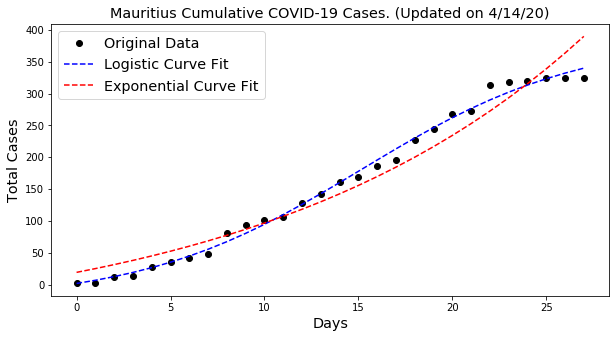



West Bank and Gaza

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 308
	Confirmed cases on 4/7/20 	 261
	Ratio: 1.18
	Weekly increase: 18.0 %
	Daily increase: 2.4 % per day
	Doubling Time (represents recent growth): 29.3 days

** Based on Logistic Fit**

	R^2: 0.9893972067332718
	Doubling Time (during middle of growth):  6.31 (± 1.01 ) days
	param:  [4.84001967e+02 2.19531289e-01 2.37454137e+01 3.25260034e+02]

** Based on Exponential Fit **

	R^2: 0.9653963726801804
	Doubling Time (represents overall growth):  13.24 (± 3.19 ) days
	param:  [ 48.05070664   0.05234352 -48.10166682]


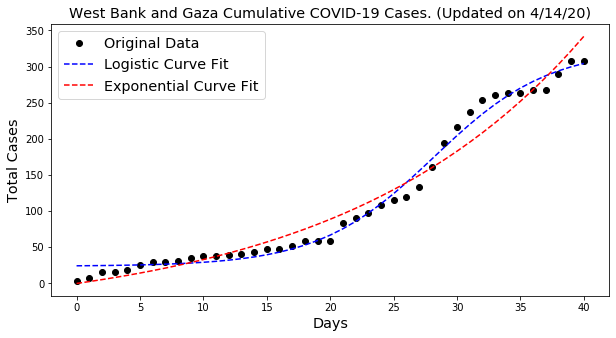



Georgia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 300
	Confirmed cases on 4/7/20 	 196
	Ratio: 1.53
	Weekly increase: 53.1 %
	Daily increase: 6.3 % per day
	Doubling Time (represents recent growth): 11.4 days

** Based on Logistic Fit**

	R^2: 0.997555525844702
	Doubling Time (during middle of growth):  15.95 (± 2.07 ) days
	param:  [ 9.37508990e+01  8.68903185e-02 -8.11503563e+00  7.28431145e+02]

** Based on Exponential Fit **

	R^2: 0.996549734401474
	Doubling Time (represents overall growth):  11.41 (± 0.61 ) days
	param:  [ 17.48458523   0.06074422 -21.99970701]


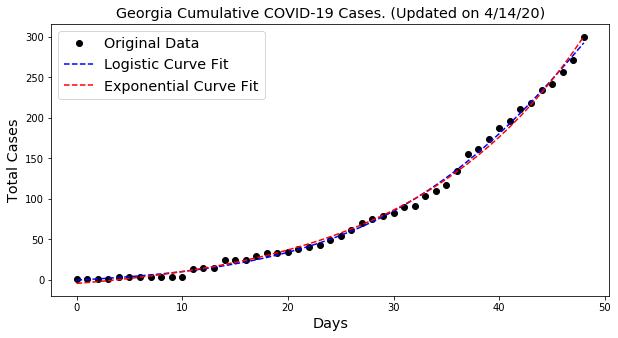



Senegal

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 299
	Confirmed cases on 4/7/20 	 237
	Ratio: 1.26
	Weekly increase: 26.2 %
	Daily increase: 3.4 % per day
	Doubling Time (represents recent growth): 20.9 days

** Based on Logistic Fit**

	R^2: 0.996919978273966
	Doubling Time (during middle of growth):  8.4 (± 0.74 ) days
	param:  [ 9.71043570e+01  1.65064976e-01 -5.81943526e+00  3.10091379e+02]

** Based on Exponential Fit **

	R^2: 0.9742391950038068
	Doubling Time (represents overall growth):  17.98 (± 4.4 ) days
	param:  [ 8.17141833e+01  3.85608264e-02 -1.00000000e+02]


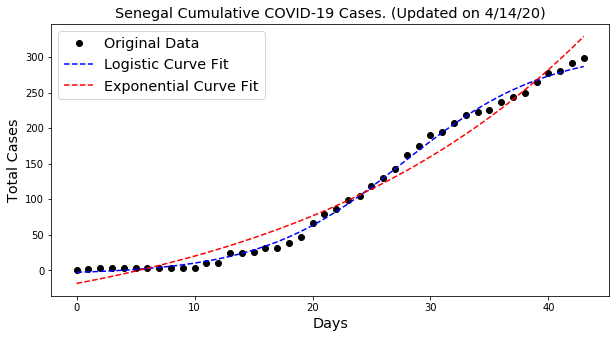



Montenegro

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 283
	Confirmed cases on 4/7/20 	 241
	Ratio: 1.17
	Weekly increase: 17.4 %
	Daily increase: 2.3 % per day
	Doubling Time (represents recent growth): 30.2 days

** Based on Logistic Fit**

	R^2: 0.9915889123326538
	Doubling Time (during middle of growth):  6.17 (± 1.2 ) days
	param:  [ 3.25980074e+01  2.24839514e-01 -3.60208556e+00  3.00115262e+02]

** Based on Exponential Fit **

	R^2: 0.9502318450015773
	Doubling Time (represents overall growth):  13.46 (± 6.59 ) days
	param:  [ 1.00000000e+02  5.15061309e-02 -9.15423755e+01]


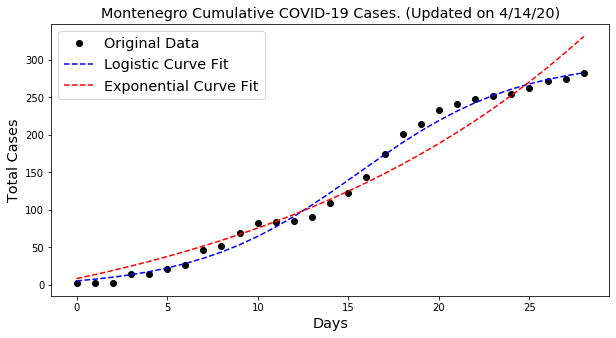



Vietnam

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 266
	Confirmed cases on 4/7/20 	 249
	Ratio: 1.07
	Weekly increase: 6.8 %
	Daily increase: 0.9 % per day
	Doubling Time (represents recent growth): 73.5 days

** Based on Logistic Fit**

	R^2: 0.9975989105738234
	Doubling Time (during middle of growth):  8.23 (± 0.41 ) days
	param:  [3.30020754e+04 1.68532070e-01 1.02496939e+01 2.75576565e+02]

** Based on Exponential Fit **

	R^2: 0.950244919291596
	Doubling Time (represents overall growth):  16.51 (± 2.35 ) days
	param:  [ 10.91386849   0.04197399 -19.6907811 ]


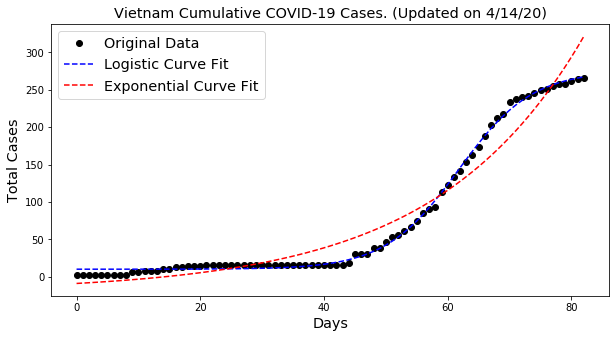



Congo (Kinshasa)

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 241
	Confirmed cases on 4/7/20 	 180
	Ratio: 1.34
	Weekly increase: 33.9 %
	Daily increase: 4.3 % per day
	Doubling Time (represents recent growth): 16.6 days

** Based on Logistic Fit**

	R^2: 0.9940144774205725
	Doubling Time (during middle of growth):  9.04 (± 1.59 ) days
	param:  [ 4.01137218e+01  1.53423750e-01 -1.00847121e+01  2.97173241e+02]

** Based on Exponential Fit **

	R^2: 0.9849266045606955
	Doubling Time (represents overall growth):  15.77 (± 3.6 ) days
	param:  [ 7.96981815e+01  4.39595657e-02 -9.46057176e+01]


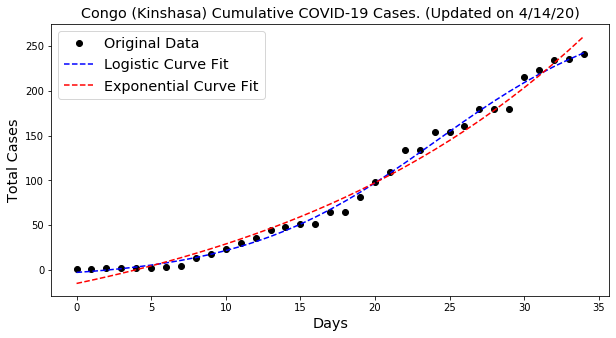



Sri Lanka

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 233
	Confirmed cases on 4/7/20 	 185
	Ratio: 1.26
	Weekly increase: 25.9 %
	Daily increase: 3.4 % per day
	Doubling Time (represents recent growth): 21.0 days

** Based on Logistic Fit**

	R^2: 0.9884826511189784
	Doubling Time (during middle of growth):  9.26 (± 1.07 ) days
	param:  [ 8.08544881e+03  1.49670055e-01 -2.00018187e+00  2.24181547e+02]

** Based on Exponential Fit **

	R^2: 0.9539059556289189
	Doubling Time (represents overall growth):  13.95 (± 1.83 ) days
	param:  [  5.63124054   0.04968359 -17.67286528]


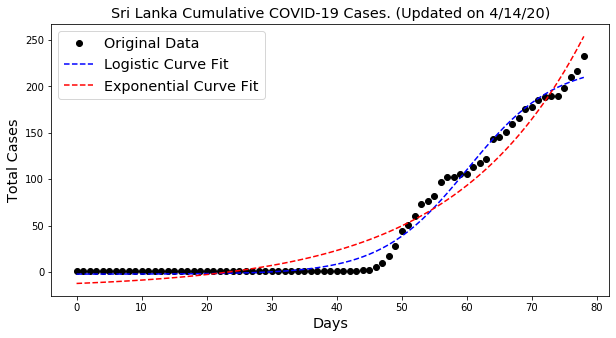



Kenya

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 216
	Confirmed cases on 4/7/20 	 172
	Ratio: 1.26
	Weekly increase: 25.6 %
	Daily increase: 3.3 % per day
	Doubling Time (represents recent growth): 21.3 days

** Based on Logistic Fit**

	R^2: 0.9954433230399028
	Doubling Time (during middle of growth):  4.91 (± 0.57 ) days
	param:  [3.48086025e+02 2.82155102e-01 3.26749800e+00 2.16923953e+02]

** Based on Exponential Fit **

	R^2: 0.96210642268326
	Doubling Time (represents overall growth):  14.09 (± 5.08 ) days
	param:  [ 6.66804288e+01  4.92102404e-02 -8.30096140e+01]


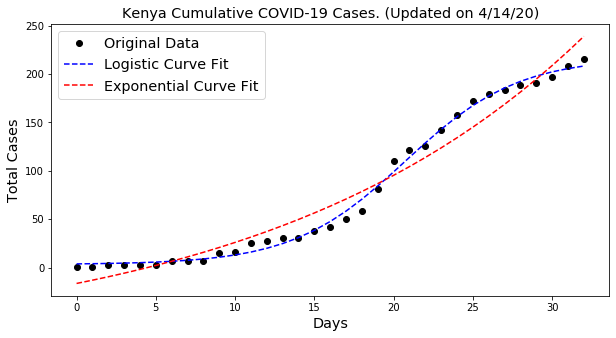



Venezuela

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 189
	Confirmed cases on 4/7/20 	 165
	Ratio: 1.15
	Weekly increase: 14.5 %
	Daily increase: 2.0 % per day
	Doubling Time (represents recent growth): 35.7 days

** Based on Logistic Fit**

	R^2: 0.9955500653830597
	Doubling Time (during middle of growth):  12.68 (± 3.37 ) days
	param:  [ 1.73234028e+00  1.09368909e-01 -1.13591053e+02  2.02305362e+02]

 exponential R^2  0.8966553640515764


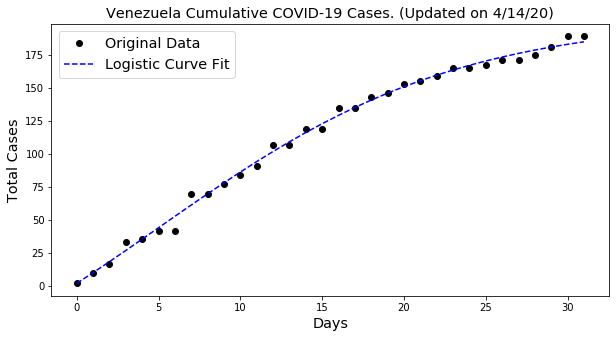



Guatemala

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 167
	Confirmed cases on 4/7/20 	 77
	Ratio: 2.17
	Weekly increase: 116.9 %
	Daily increase: 11.7 % per day
	Doubling Time (represents recent growth): 6.3 days

** Based on Logistic Fit**

	R^2: 0.9876428347042411
	Doubling Time (during middle of growth):  13.13 (± 6.57 ) days
	param:  [ 1.57250276e+07  1.05619782e-01 -1.49693854e+00  1.05534591e+08]

** Based on Exponential Fit **

	R^2: 0.9876428352670844
	Doubling Time (represents overall growth):  6.56 (± 0.77 ) days
	param:  [ 6.71127942  0.10561961 -1.49698386]


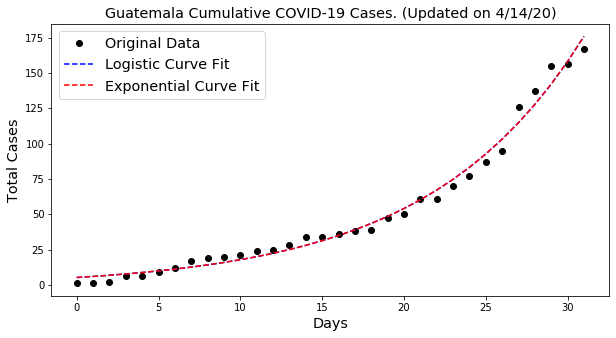



Paraguay

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 159
	Confirmed cases on 4/7/20 	 115
	Ratio: 1.38
	Weekly increase: 38.3 %
	Daily increase: 4.7 % per day
	Doubling Time (represents recent growth): 15.0 days

** Based on Logistic Fit**

	R^2: 0.9949540523538629
	Doubling Time (during middle of growth):  9.43 (± 1.4 ) days
	param:  [ 4.52626211e+01  1.47070946e-01 -4.02168418e+00  1.79640716e+02]

** Based on Exponential Fit **

	R^2: 0.9849192695761433
	Doubling Time (represents overall growth):  16.64 (± 3.54 ) days
	param:  [ 4.62860350e+01  4.16522602e-02 -5.40252568e+01]


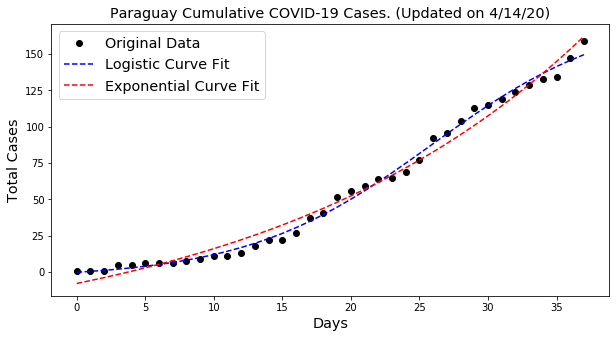



El Salvador

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 149
	Confirmed cases on 4/7/20 	 78
	Ratio: 1.91
	Weekly increase: 91.0 %
	Daily increase: 9.7 % per day
	Doubling Time (represents recent growth): 7.5 days

** Based on Logistic Fit**

	R^2: 0.9969301241737767
	Doubling Time (during middle of growth):  8.03 (± 1.4 ) days
	param:  [ 4.37940099e+01  1.72647929e-01 -4.66426189e+00  2.22283078e+02]

** Based on Exponential Fit **

	R^2: 0.9928672245592064
	Doubling Time (represents overall growth):  9.04 (± 1.27 ) days
	param:  [ 24.97379169   0.07670911 -29.25783351]


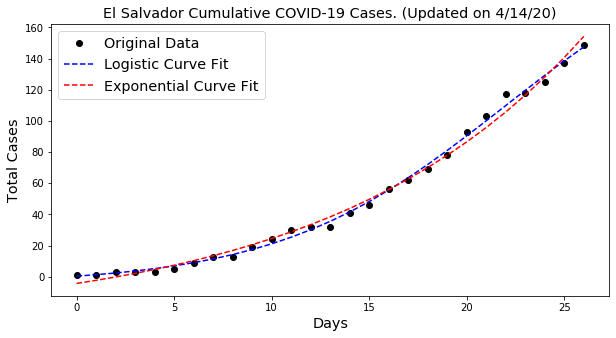



Mali

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 144
	Confirmed cases on 4/7/20 	 56
	Ratio: 2.57
	Weekly increase: 157.1 %
	Daily increase: 14.4 % per day
	Doubling Time (represents recent growth): 5.1 days

** Based on Logistic Fit**

	R^2: 0.9858963861531725
	Doubling Time (during middle of growth):  11.45 (± 2.1 ) days
	param:  [ 2.65039619e+08  1.21097773e-01 -2.78339283e+00  3.31476554e+09]

** Based on Exponential Fit **

	R^2: 0.9858963864981715
	Doubling Time (represents overall growth):  5.72 (± 1.11 ) days
	param:  [12.50678853  0.12109737 -2.78355694]


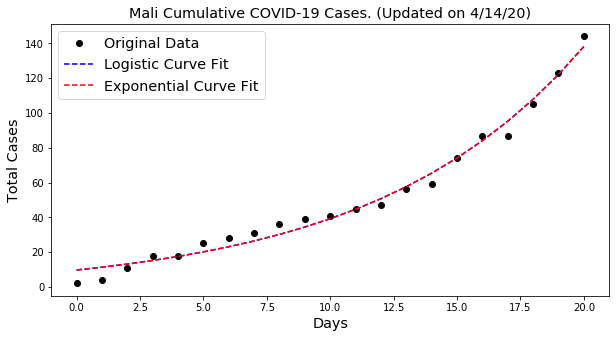



Brunei

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 136
	Confirmed cases on 4/7/20 	 135
	Ratio: 1.01
	Weekly increase: 0.7 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 657.4 days

** Based on Logistic Fit**

	R^2: 0.9933900408925045
	Doubling Time (during middle of growth):  8.69 (± 1.52 ) days
	param:  [  2.44516044   0.15952122 -59.13999554 140.08314123]

 exponential R^2  0.7795178477182376


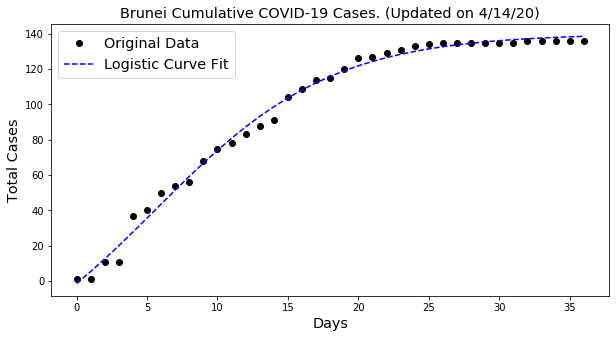



Rwanda

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 134
	Confirmed cases on 4/7/20 	 105
	Ratio: 1.28
	Weekly increase: 27.6 %
	Daily increase: 3.5 % per day
	Doubling Time (represents recent growth): 19.9 days

** Based on Logistic Fit**

	R^2: 0.9941463352014656
	Doubling Time (during middle of growth):  9.98 (± 2.17 ) days
	param:  [ 7.19174967e+00  1.38871821e-01 -2.27566948e+01  1.42931116e+02]

** Based on Exponential Fit **

	R^2: 0.9655575614676931
	Doubling Time (represents overall growth):  24.27 (± 14.63 ) days
	param:  [ 1.00000000e+02  2.85579487e-02 -9.56823570e+01]


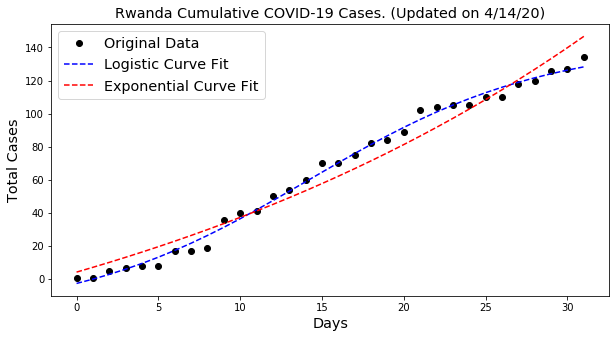



Cambodia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 122
	Confirmed cases on 4/7/20 	 115
	Ratio: 1.06
	Weekly increase: 6.1 %
	Daily increase: 0.8 % per day
	Doubling Time (represents recent growth): 82.1 days

** Based on Logistic Fit**

	R^2: 0.9946656494298758
	Doubling Time (during middle of growth):  3.81 (± 0.35 ) days
	param:  [3.17189033e+08 3.64262058e-01 6.12554584e-01 1.15371577e+02]

 exponential R^2  0.8774434128242096


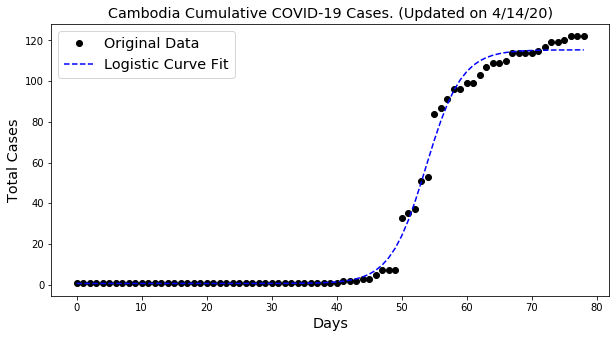



Trinidad and Tobago

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 113
	Confirmed cases on 4/7/20 	 107
	Ratio: 1.06
	Weekly increase: 5.6 %
	Daily increase: 0.8 % per day
	Doubling Time (represents recent growth): 88.9 days

** Based on Logistic Fit**

	R^2: 0.9788550026345733
	Doubling Time (during middle of growth):  7.94 (± 2.72 ) days
	param:  [  4.25210913   0.17459143 -33.49834003 115.47533193]

 exponential R^2  0.8624415661421706


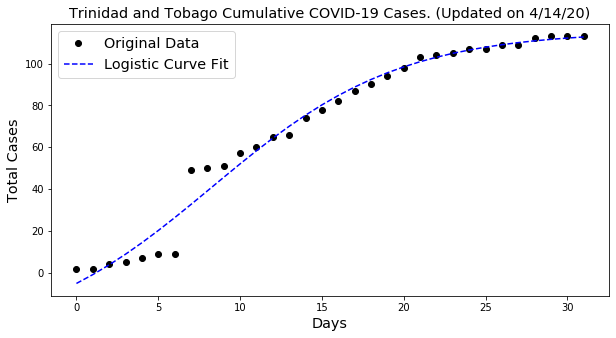



Madagascar

** Based on Most Recent Week of Data **

	Confirmed cases on 4/14/20 	 108
	Confirmed cases on 4/7/20 	 88
	Ratio: 1.23
	Weekly increase: 22.7 %
	Daily increase: 3.0 % per day
	Doubling Time (represents recent growth): 23.7 days

** Based on Logistic Fit**

	R^2: 0.9931161647578921
	Doubling Time (during middle of growth):  8.37 (± 2.32 ) days
	param:  [  6.66354707   0.1655682  -17.07908624 121.35486751]

** Based on Exponential Fit **

	R^2: 0.9683676805273091
	Doubling Time (represents overall growth):  22.52 (± 16.57 ) days
	param:  [ 1.00000000e+02  3.07752858e-02 -9.43224134e+01]


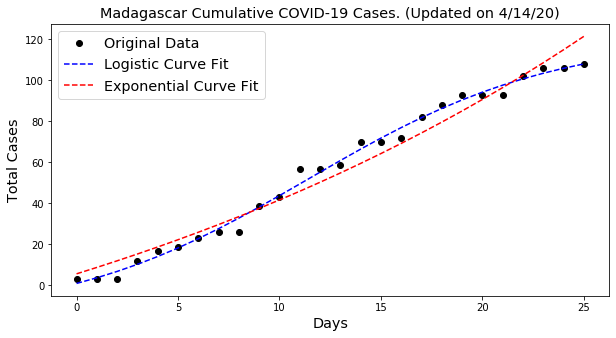

In [6]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

cnames = topcountries.values

for c in cnames:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


     Inferred Doubling Time  95%CI  Recent Doubling Time
0                       7.3    0.2                  11.3
1                       7.4    0.2                  24.9
2                       9.8    0.4                  26.8
3                       7.7    0.5                  27.4
4                       7.8    0.2                  24.4
5                       8.2    0.3                   9.2
6                       6.7    0.4                 685.0
7                      13.2    1.0                  27.1
8                       7.8    0.6                   7.5
9                       8.1    0.3                  14.4
10                      9.9    0.7                  14.4
11                      7.4    0.2                  11.7
12                      8.1    0.5                 

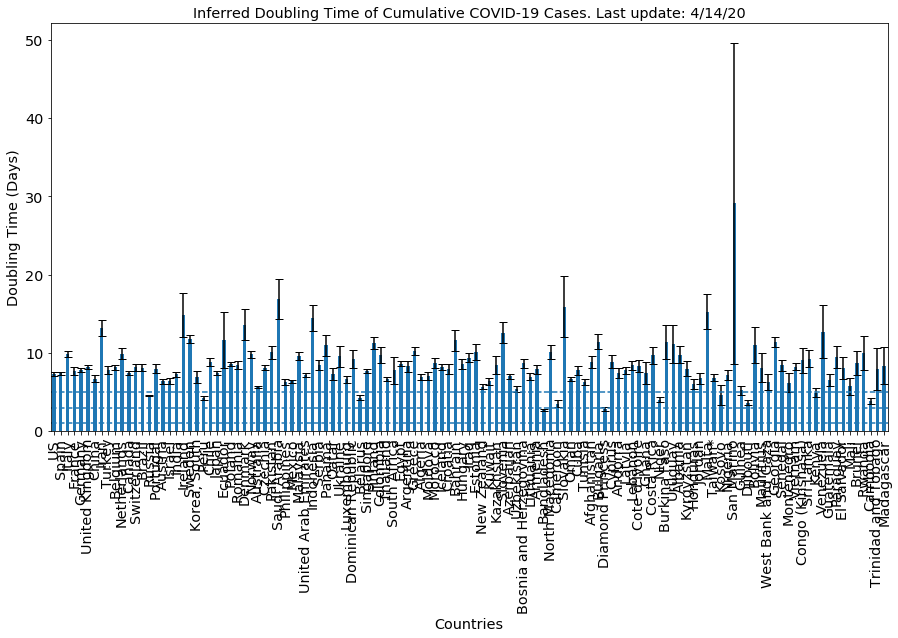

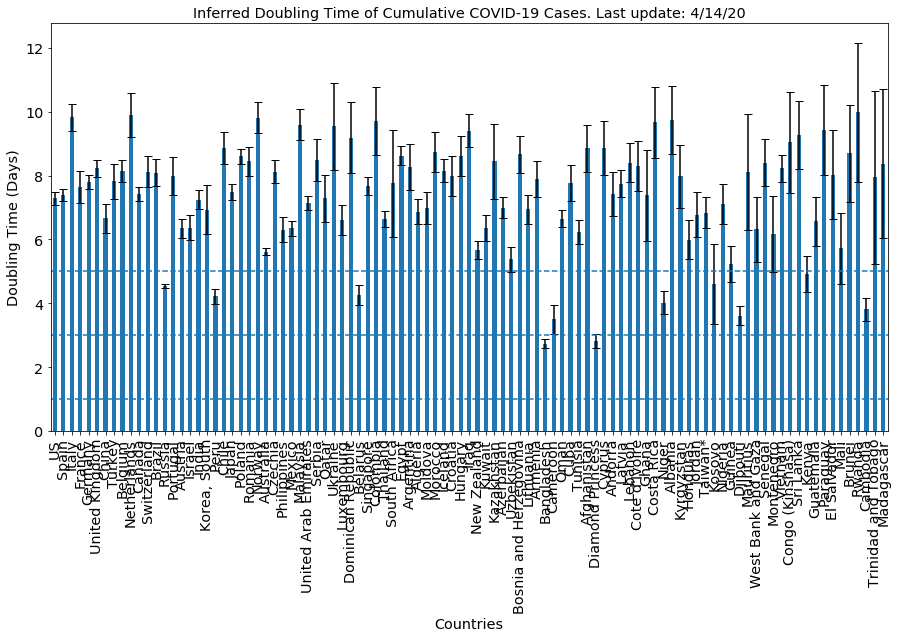

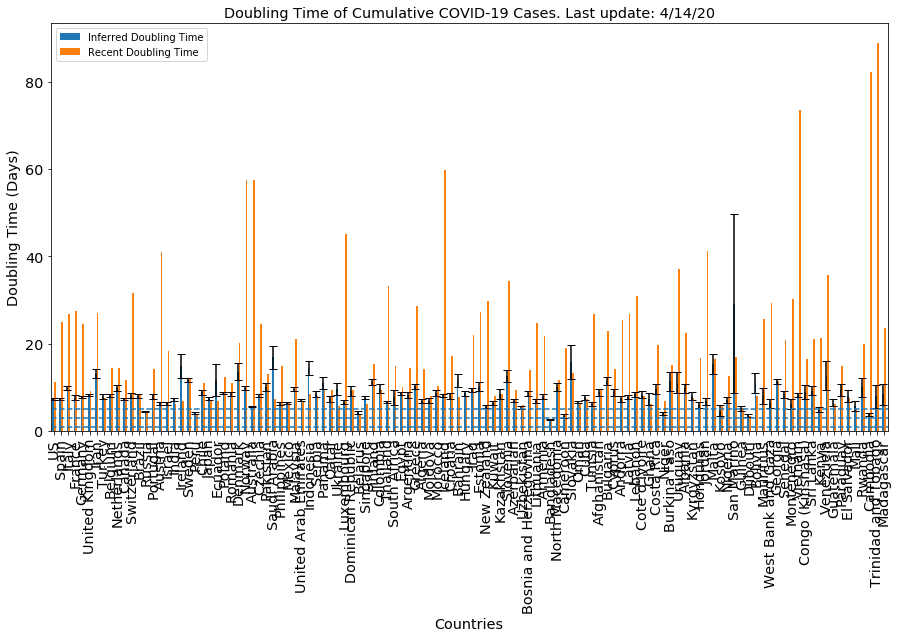

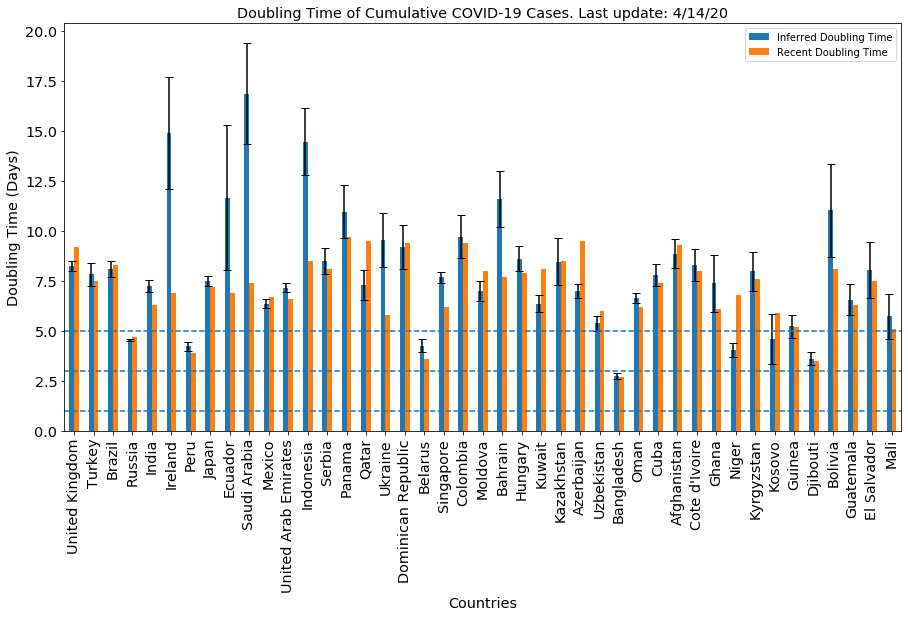

In [7]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()